## **NLP Project**

### Table of contents:
- Data and libraries import
- Training a Bi-Directional LSTM model
    - Hyperparameter optimization
- Training a Bi-Directional LSTM model with attention
- Fine-Tuning a pre-trained BERT Model
    - Hyperparameter Optimization
- Results  

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
import warnings
warnings.filterwarnings("ignore")

In [84]:
from matplotlib.colors import ListedColormap

custom_colors = sns.color_palette("crest", 3)
jco_cmap = ListedColormap(custom_colors)

sns.set_theme(palette='crest', font='Sans-Serif')
plt.style.use('Solarize_Light2')

In [85]:
data = pd.read_csv('Symptom2Disease.csv')
data

Unnamed: 0      label                                               text
0              0  Psoriasis  I have been experiencing a skin rash on my arm...
1              1  Psoriasis  My skin has been peeling, especially on my kne...
2              2  Psoriasis  I have been experiencing joint pain in my fing...
3              3  Psoriasis  There is a silver like dusting on my skin, esp...
4              4  Psoriasis  My nails have small dents or pits in them, and...
...          ...        ...                                                ...
1195         295   diabetes  I'm shaking and trembling all over. I've lost ...
1196         296   diabetes  Particularly in the crevices of my skin, I hav...
1197         297   diabetes  I regularly experience these intense urges and...
1198         298   diabetes  I have trouble breathing, especially outside. ...
1199         299   diabetes  I constantly sneeze and have a dry cough. My i...

[1200 rows x 3 columns]

In [86]:
X = data['text'].to_numpy()
y_cat = data['label'].to_numpy()
class_labels = np.unique(y_cat)

In [87]:
X.shape, y_cat.shape

((1200,), (1200,))

In [88]:
X

array(['I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches.',
       'My skin has been peeling, especially on my knees, elbows, and scalp. This peeling is often accompanied by a burning or stinging sensation.',
       'I have been experiencing joint pain in my fingers, wrists, and knees. The pain is often achy and throbbing, and it gets worse when I move my joints.',
       ...,
       "I regularly experience these intense urges and the want to urinate. I frequently feel drowsy and lost. I've also significantly lost my vision.",
       'I have trouble breathing, especially outside. I start to feel hot and start to sweat. I frequently have urinary tract infections and yeast infections.',
       "I constantly sneeze and have a dry cough. My infections don't seem to be healing, and I have palpitations. My throat does ache occasionally, but it usually gets better."],
      dtype=object)

In [89]:
y_cat

array(['Psoriasis', 'Psoriasis', 'Psoriasis', ..., 'diabetes', 'diabetes',
       'diabetes'], dtype=object)

In [90]:
# Inspecting our target variable
classes, counts = np.unique(y_cat, return_counts=True)
count = np.asarray((classes, counts)).T
freq = [(count[i, 1]/1200) * 100 for i in range(count.shape[0])]
                   

In [91]:
# getting the most frequent words in the symptoms
from collections import  Counter

corpus = []
for x in data['text'].str.split():
    corpus.extend(x)
counter = Counter(corpus)
most = counter.most_common()
words = [word for word, count in most[:25]]
counts = [count for word, count in most[:25]]
    

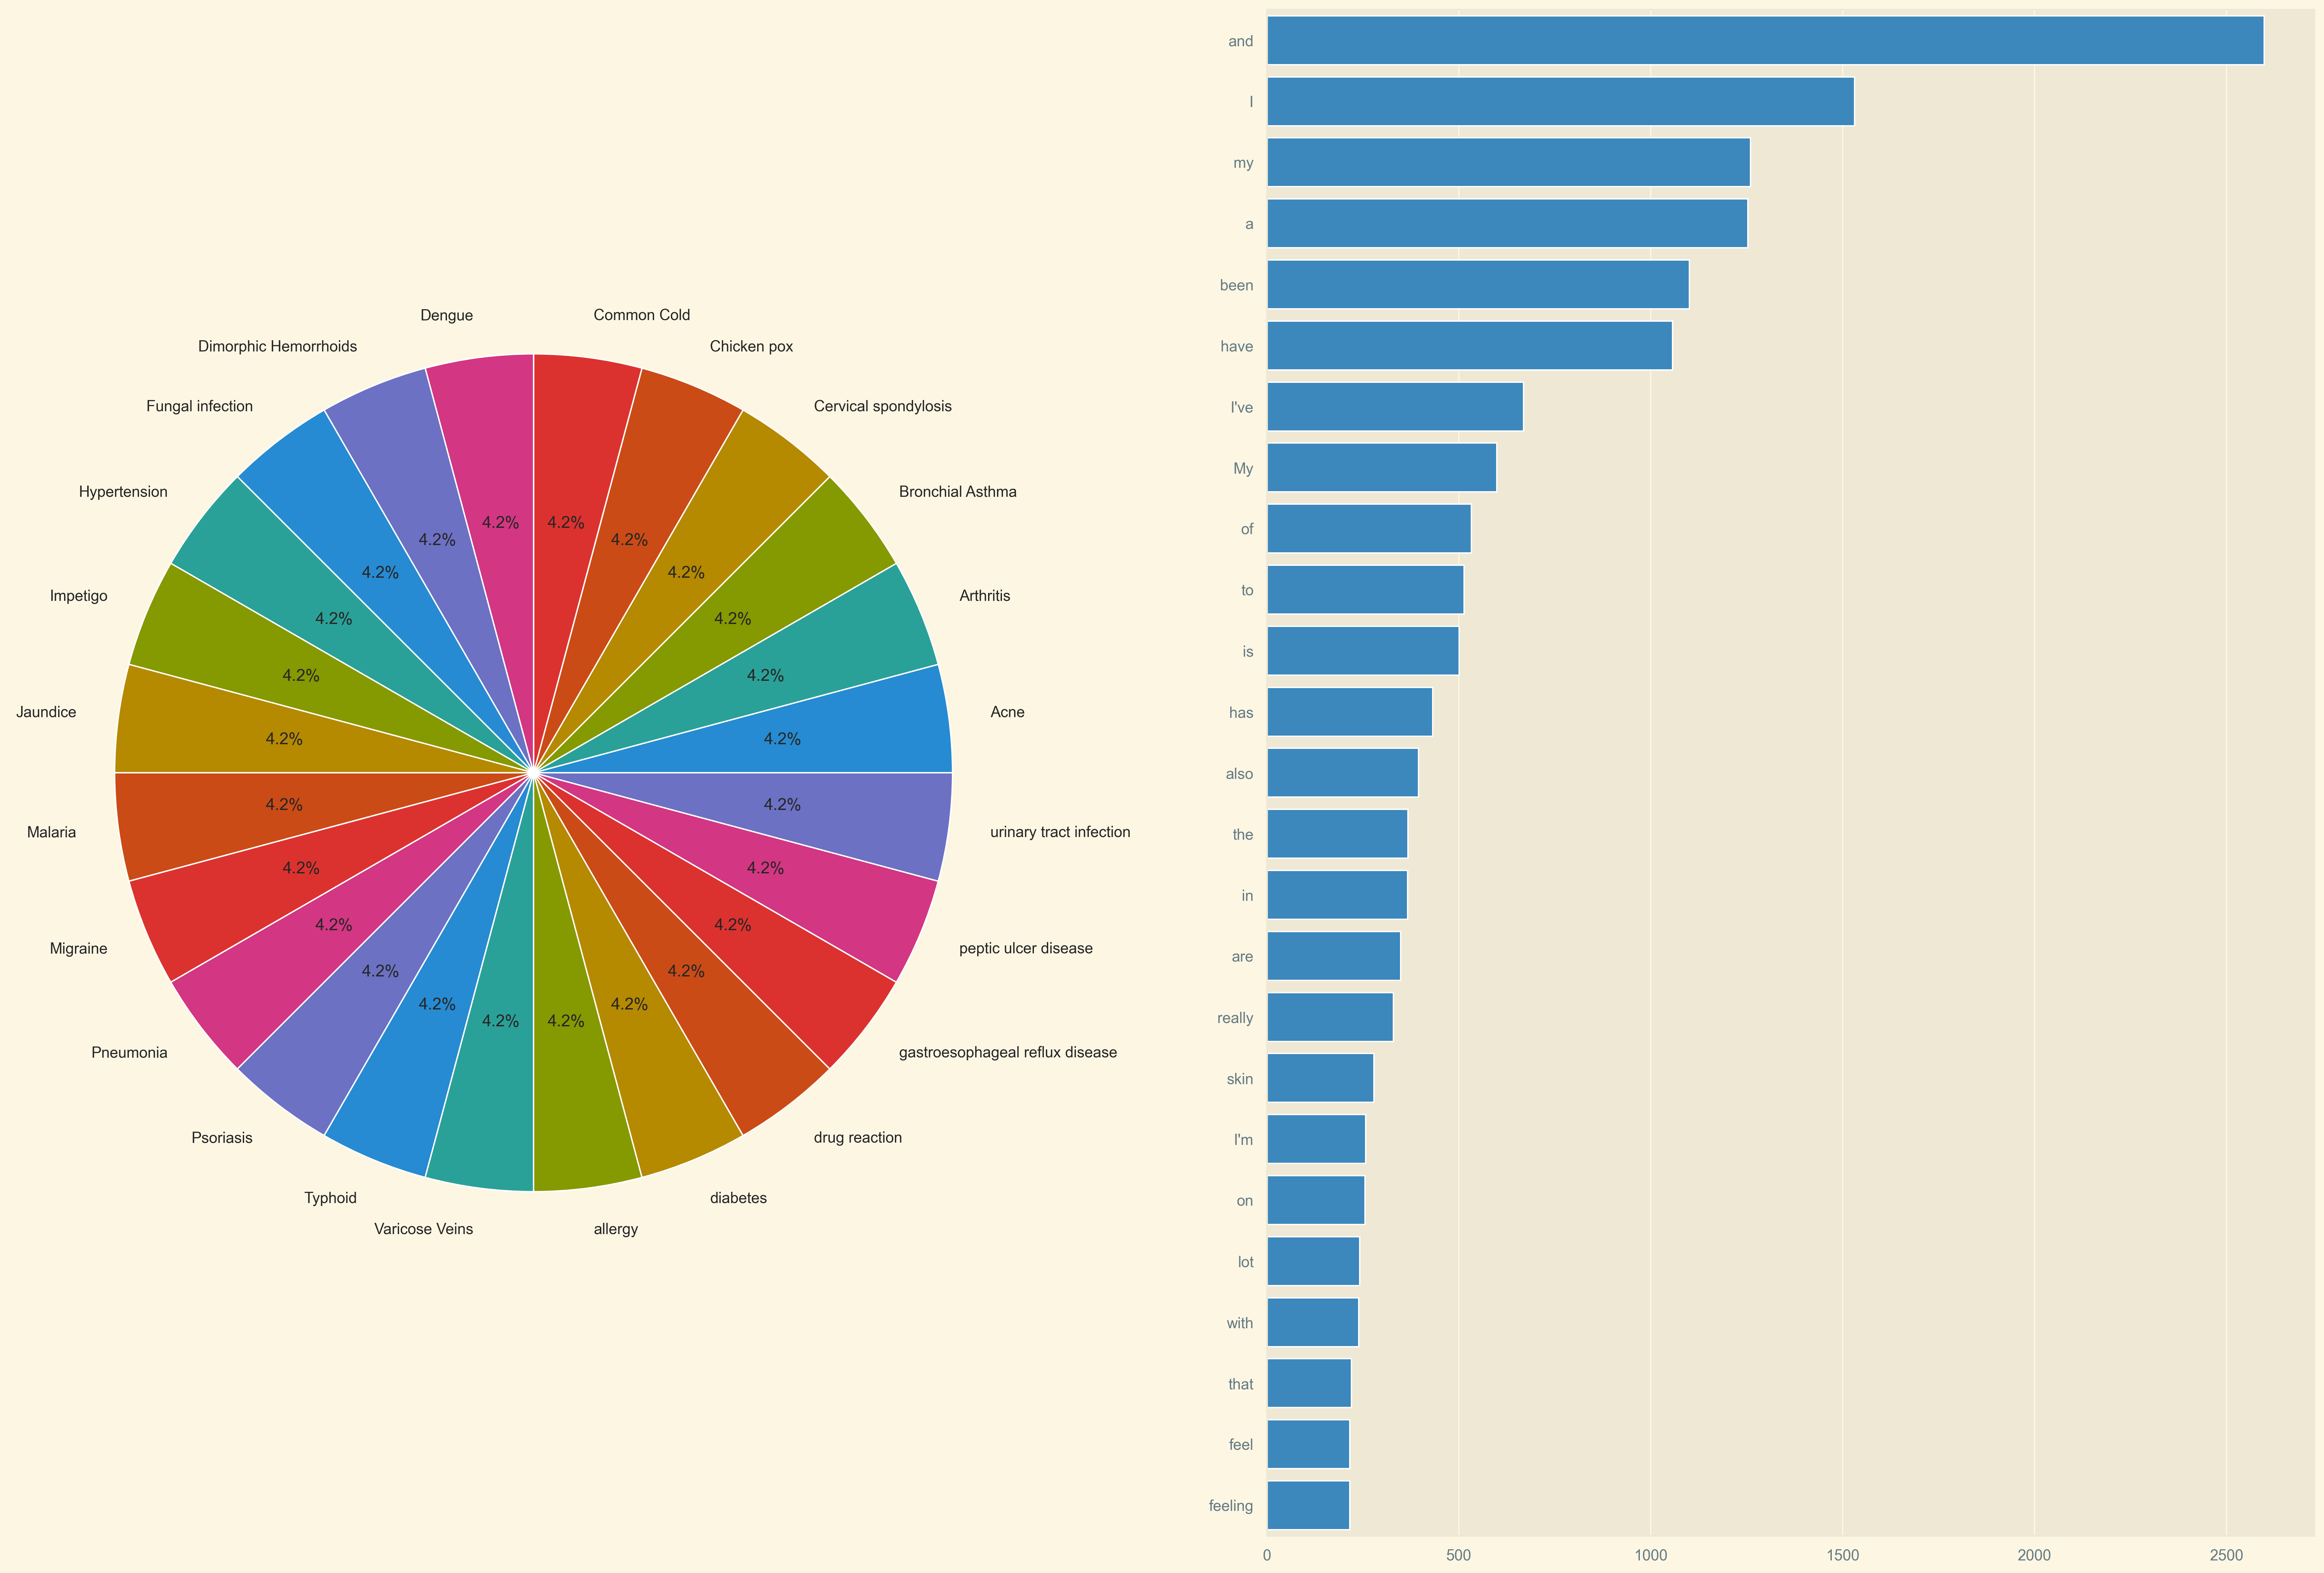

In [92]:
fig, ax = plt.subplots(1,2, figsize=(30,20), dpi=300)
ax[0].pie(freq, labels=class_labels, autopct='%1.1f%%')
sns.barplot(x=counts, y=words, ax=ax[1])
plt.show()

We have already exported our required data and we have also checked the distribution of our classes which is completely balanced.
Now we can start with the data preprocessing step. We have decided to to the preprocessing ourselves.

In [93]:
import nltk
from nltk.corpus import stopwords
import string
import re
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords') 
nltk.download("wordnet")
nltk.download("omw-1.4")
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [214]:
from transformers import AutoTokenizer

class PreprocessText():
    def __init__(self, data):
        self.data = data if isinstance(data, list) else [data]
        self.tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english") # tokenizer for the Bert Model

    def tokenization(self, padding=False):
        '''Function for tokenization and lemmatization'''
        lem = WordNetLemmatizer()
        punc = string.punctuation
        STOPWORDS = stopwords.words('english')
        
        tokens = []
        for symptom in self.data:
            words = [lem.lemmatize(word, pos='v') for word in symptom.strip().lower().split() if word not in STOPWORDS]
            words = [''.join(char for char in word if char not in punc) for word in words]
            words = [word for word in words if word]
            tokens.append(words)
                
        if padding:
            tokens = self.padding(tokens)
        return np.array(tokens)

    def tokenization_bert(self, max_length):
        '''Function for tokenization for BERT, as it requires as input the mapping of
        the text to integers (each input unique id) and a vector of boolean values (0/1)
        with the masks for the padding tokens, so that the don't get conidered by the
        attention mechanism'''
        tokenized_data = []
        attention_mask = []
        
        for symptom in self.data:
            encoded_dict = self.tokenizer.encode_plus(
                symptom,
                max_length=max_length,
                truncation=True,
                add_special_tokens=True,      
                pad_to_max_length=True,       
                return_attention_mask=True          
            )
            tokenized_data.append(encoded_dict['input_ids'])
            attention_mask.append(encoded_dict['attention_mask'])
        return np.array(tokenized_data), np.array(attention_mask)
                    
    
    @staticmethod
    def padding(tokenized_text):
        '''This function pads the text for classification, it pads only the
        left side of the input to lenght = max_lenght + 2'''
        MAX_LEN = max(len(x) for x in tokenized_text) + 2
        special_token = '[PAD]'
        for symptom in tokenized_text:
            num_pad = MAX_LEN - len(symptom)
            if len(symptom) != MAX_LEN:
                for _ in range(num_pad):
                    symptom.insert(0, special_token)
        return tokenized_text

    @staticmethod
    def transform_int(data, vocab):
        '''Function for transforming our words to their integer representation'''
        if len(data.shape) > 1:
            for sentence in data:
                for i in range(len(sentence)):
                    sentence[i] = vocab.get(sentence[i])
        else:
            for i in range(len(data)):
                data[i] = vocab.get(data[i])
        
        return np.array(data, dtype=np.int32)
    
    @staticmethod
    def create_vocab(tokenized_text):
        '''This function creates a vocabulary'''
        unique_words = np.unique(tokenized_text)
        vocab = {word: i for i, word in enumerate(unique_words)}
        return vocab

In [95]:
pre_process = Preprocess_text(X)
tokens = pre_process.tokenization(padding=True)
vocab = pre_process.create_vocab(tokens)
X_clean = pre_process.transform_int(tokens, vocab)

In [223]:
X_clean[:5] # showing the final processed text

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  430, 1106,  976,
          79,  702, 1279,  894, 1381,  996,  672,  259,  372, 1043,  896],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1106,
         901,  407,  684,  384, 1042,  900,  867,   11,  167, 1163, 1061],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  430,  675,  885,
         476, 1413,  684,  885,  867,   15, 1250,  537, 1407,  791,  676],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 1095,  712,  375, 1106,  407,
         731,   89, 1042,  375,  740, 1118, 1040,  483,  377, 1048, 1234],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

In [98]:
# lenght of the vocabulary
print(len(vocab))

1423


In [99]:
# len of our input
X_clean.shape[1]

33

In [100]:
target = pre_process.create_vocab(y_cat)
y_int = pre_process.transform_int(y_cat, target)

In [101]:
y_int # integer mapping of our target

array([15, 15, 15, ..., 19, 19, 19])

In [102]:
from sklearn.model_selection import train_test_split

# splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_int, test_size=0.2, stratify=y_int, random_state=42)

In [103]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((960, 33), (240, 33), (960,), (240,))

## Building the Model

- The structure of the model will be a Bidirectional LSTM, with number of temporal steps equal to the lenght of our input sentences, 33 in our case. With an embedding layer, to get the embeddings of our tokens and an output layer with a softmax activation funtion to get the probability distribution over our 24 classes 

In [104]:
import tensorflow.keras as tf
from keras import layers
from keras import Model
import keras
import tensorflow

class Bi_LSTM(tf.Model):
    def __init__(self, input_shape: int, batch_size: int, n_unique_words: int, output_dim: int, num_classes: int, n_units: int, rate: float, activation='softmax'):
        super(Bi_LSTM, self).__init__()
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.n_unique_words = n_unique_words
        self.output_dim = output_dim
        self.num_classes = num_classes
        self.n_units = n_units
        self.rate = rate
        self.activation = activation

        self.model = self.create_model()

    def create_model(self):
        '''
        Creates Bi-Directional LSTM model
        '''
        inputs = layers.Input(shape=(self.input_shape,), batch_size=self.batch_size)
        emb = layers.Embedding(
            input_dim=self.n_unique_words + 1, # because masking = true we need to provide the leb of the vocab + 1 as the first value will not be considered
            output_dim=self.output_dim,
            mask_zero=True
        )(inputs)
        bi_lstm = layers.Bidirectional(layers.LSTM(self.n_units))(emb)
        x = layers.Dropout(self.rate)(bi_lstm)
        output = layers.Dense(self.num_classes, activation=self.activation)(x)
        model = Model(inputs, output, name='BiLSTM')
        return model

    def update_model(self, output_dim=None, n_units=None, rate=None):
        '''Updates model hyperparameters'''
        if output_dim is not None:
            self.output_dim = output_dim
        if n_units is not None:
            self.n_units = n_units
        if rate is not None:
            self.rate = rate 
        self.model = self.create_model()

    def print_summary(self):
        '''Prints a summary of the model'''
        return self.model.summary()
    
    def call(self, inputs):
        return self.model(inputs)

First we will test our model in using the whole training and test sets with base parameters, to check the base performance of the model

In [105]:
model = Bi_LSTM(
    input_shape=X_clean.shape[1], 
    batch_size=16, 
    n_unique_words=len(vocab), 
    output_dim=50, 
    num_classes=len(target),
    n_units=64,
    rate=0.5
)

In [106]:
model.print_summary()

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (16, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (16, 33, 50)      │     71,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (16, 33)          │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (16, 128)         │     58,880 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (16, 128)         │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (16, 24)          │      3,096 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,176 (520.22 KB)

 Trainable params: 133,176 (520.22 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
model.compile(
    optimizer= tf.optimizers.Adam(learning_rate=1*10**-3),
    loss='sparse_categorical_crossentropy',
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)
model.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=10,
    #validation_data=(X_test, y_test)
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.1497 - sparse_categorical_accuracy: 0.1244
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2108 - sparse_categorical_accuracy: 0.3509
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1890 - sparse_categorical_accuracy: 0.6875
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5923 - sparse_categorical_accuracy: 0.8830
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2787 - sparse_categorical_accuracy: 0.9635
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.9828
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0906 - sparse_categorical_accuracy: 0.9936
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0695 - sparse_categorical_accuracy: 0.9962
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0384 - sparse_categorical_accuracy: 0.9998
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0261 - spars

In [108]:
y_preds = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [109]:
preds = np.argmax(y_preds, axis=1)
acc = [1 if y_test[i] == preds[i] else 0 for i in range(len(preds))]
np.mean(acc)

0.85

In [110]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Useful functions for plotting

def class_report(y_true, y_pred, class_labels):
    '''This function will give the detailed performance of the model for each class'''
    report = pd.DataFrame(classification_report(
      y_true=y_true, y_pred=y_pred,
      target_names=class_labels, output_dict=True))
    return report

def plot_confusion_matrix(cm, ax, report, class_labels, att=False, bert=False):
    color_map = 'flare' if att else 'icefire' if bert else 'crest'
    sns.heatmap(cm,
                annot=True,
                xticklabels=class_labels,
                yticklabels=class_labels,
                ax=ax,
                cmap=color_map)
    ax.set_xlabel('Prediction', fontsize=13) 
    ax.set_ylabel('Actual', fontsize=13)
    ax.set_title(f'Confusion Matrix')
    plt.show()

def plot_score_epochs(fig, axis, history_model, emb_dim, n_units, learning_rate):
    acc_train = history_model.history['sparse_categorical_accuracy']
    epochs = range(1, len(acc_train) + 1)
    axis.plot(epochs, acc_train, label='Training F1-Score')
    axis.set_title("Training score")
    axis.set_xlabel('Epoch')
    axis.set_ylabel('Score')
    fig.suptitle(f"F1-score vs Epochs with embedding dimension {emb_dim}, {n_units} number of units of LSTM, {learning_rate:.4f} learning rate")
    plt.show()

In [111]:
report = class_report(y_test, preds, class_labels) 

In [112]:
report

Acne  Arthritis  Bronchial Asthma  Cervical spondylosis  \
precision   1.0        1.0          1.000000              0.833333   
recall      1.0        1.0          0.900000              1.000000   
f1-score    1.0        1.0          0.947368              0.909091   
support    10.0       10.0         10.000000             10.000000   

           Chicken pox  Common Cold     Dengue  Dimorphic Hemorrhoids  \
precision     0.636364     0.818182   0.615385                    1.0   
recall        0.700000     0.900000   0.800000                    1.0   
f1-score      0.666667     0.857143   0.695652                    1.0   
support      10.000000    10.000000  10.000000                   10.0   

           Fungal infection  Hypertension  ...  Varicose Veins    allergy  \
precision               1.0      1.000000  ...        1.000000   0.750000   
recall                  1.0      0.800000  ...        0.800000   0.600000   
f1-score                1.0      0.888889  ...        0.888889   0.666667   
support                10.0     10.000000  ...       10.000000  10.000000   

            diabetes  drug reaction  gastroesophageal reflux disease  \
precision   0.727273       0.666667                              0.9   
recall      0.800000       0.400000                              0.9   
f1-score    0.761905       0.500000                              0.9   
support    10.000000      10.000000                             10.0   

           peptic ulcer disease  urinary tract infection  accuracy  \
precision              1.000000                 0.666667      0.85   
recall                 0.700000                 0.800000      0.85   
f1-score               0.823529                 0.727273      0.85   
support               10.000000                10.000000      0.85   

            macro avg  weighted avg  
precision    0.860066      0.860066  
recall       0.850000      0.850000  
f1-score     0.848616      0.848616  
support    240.000000    240.000000  

[4 rows x 27 columns]

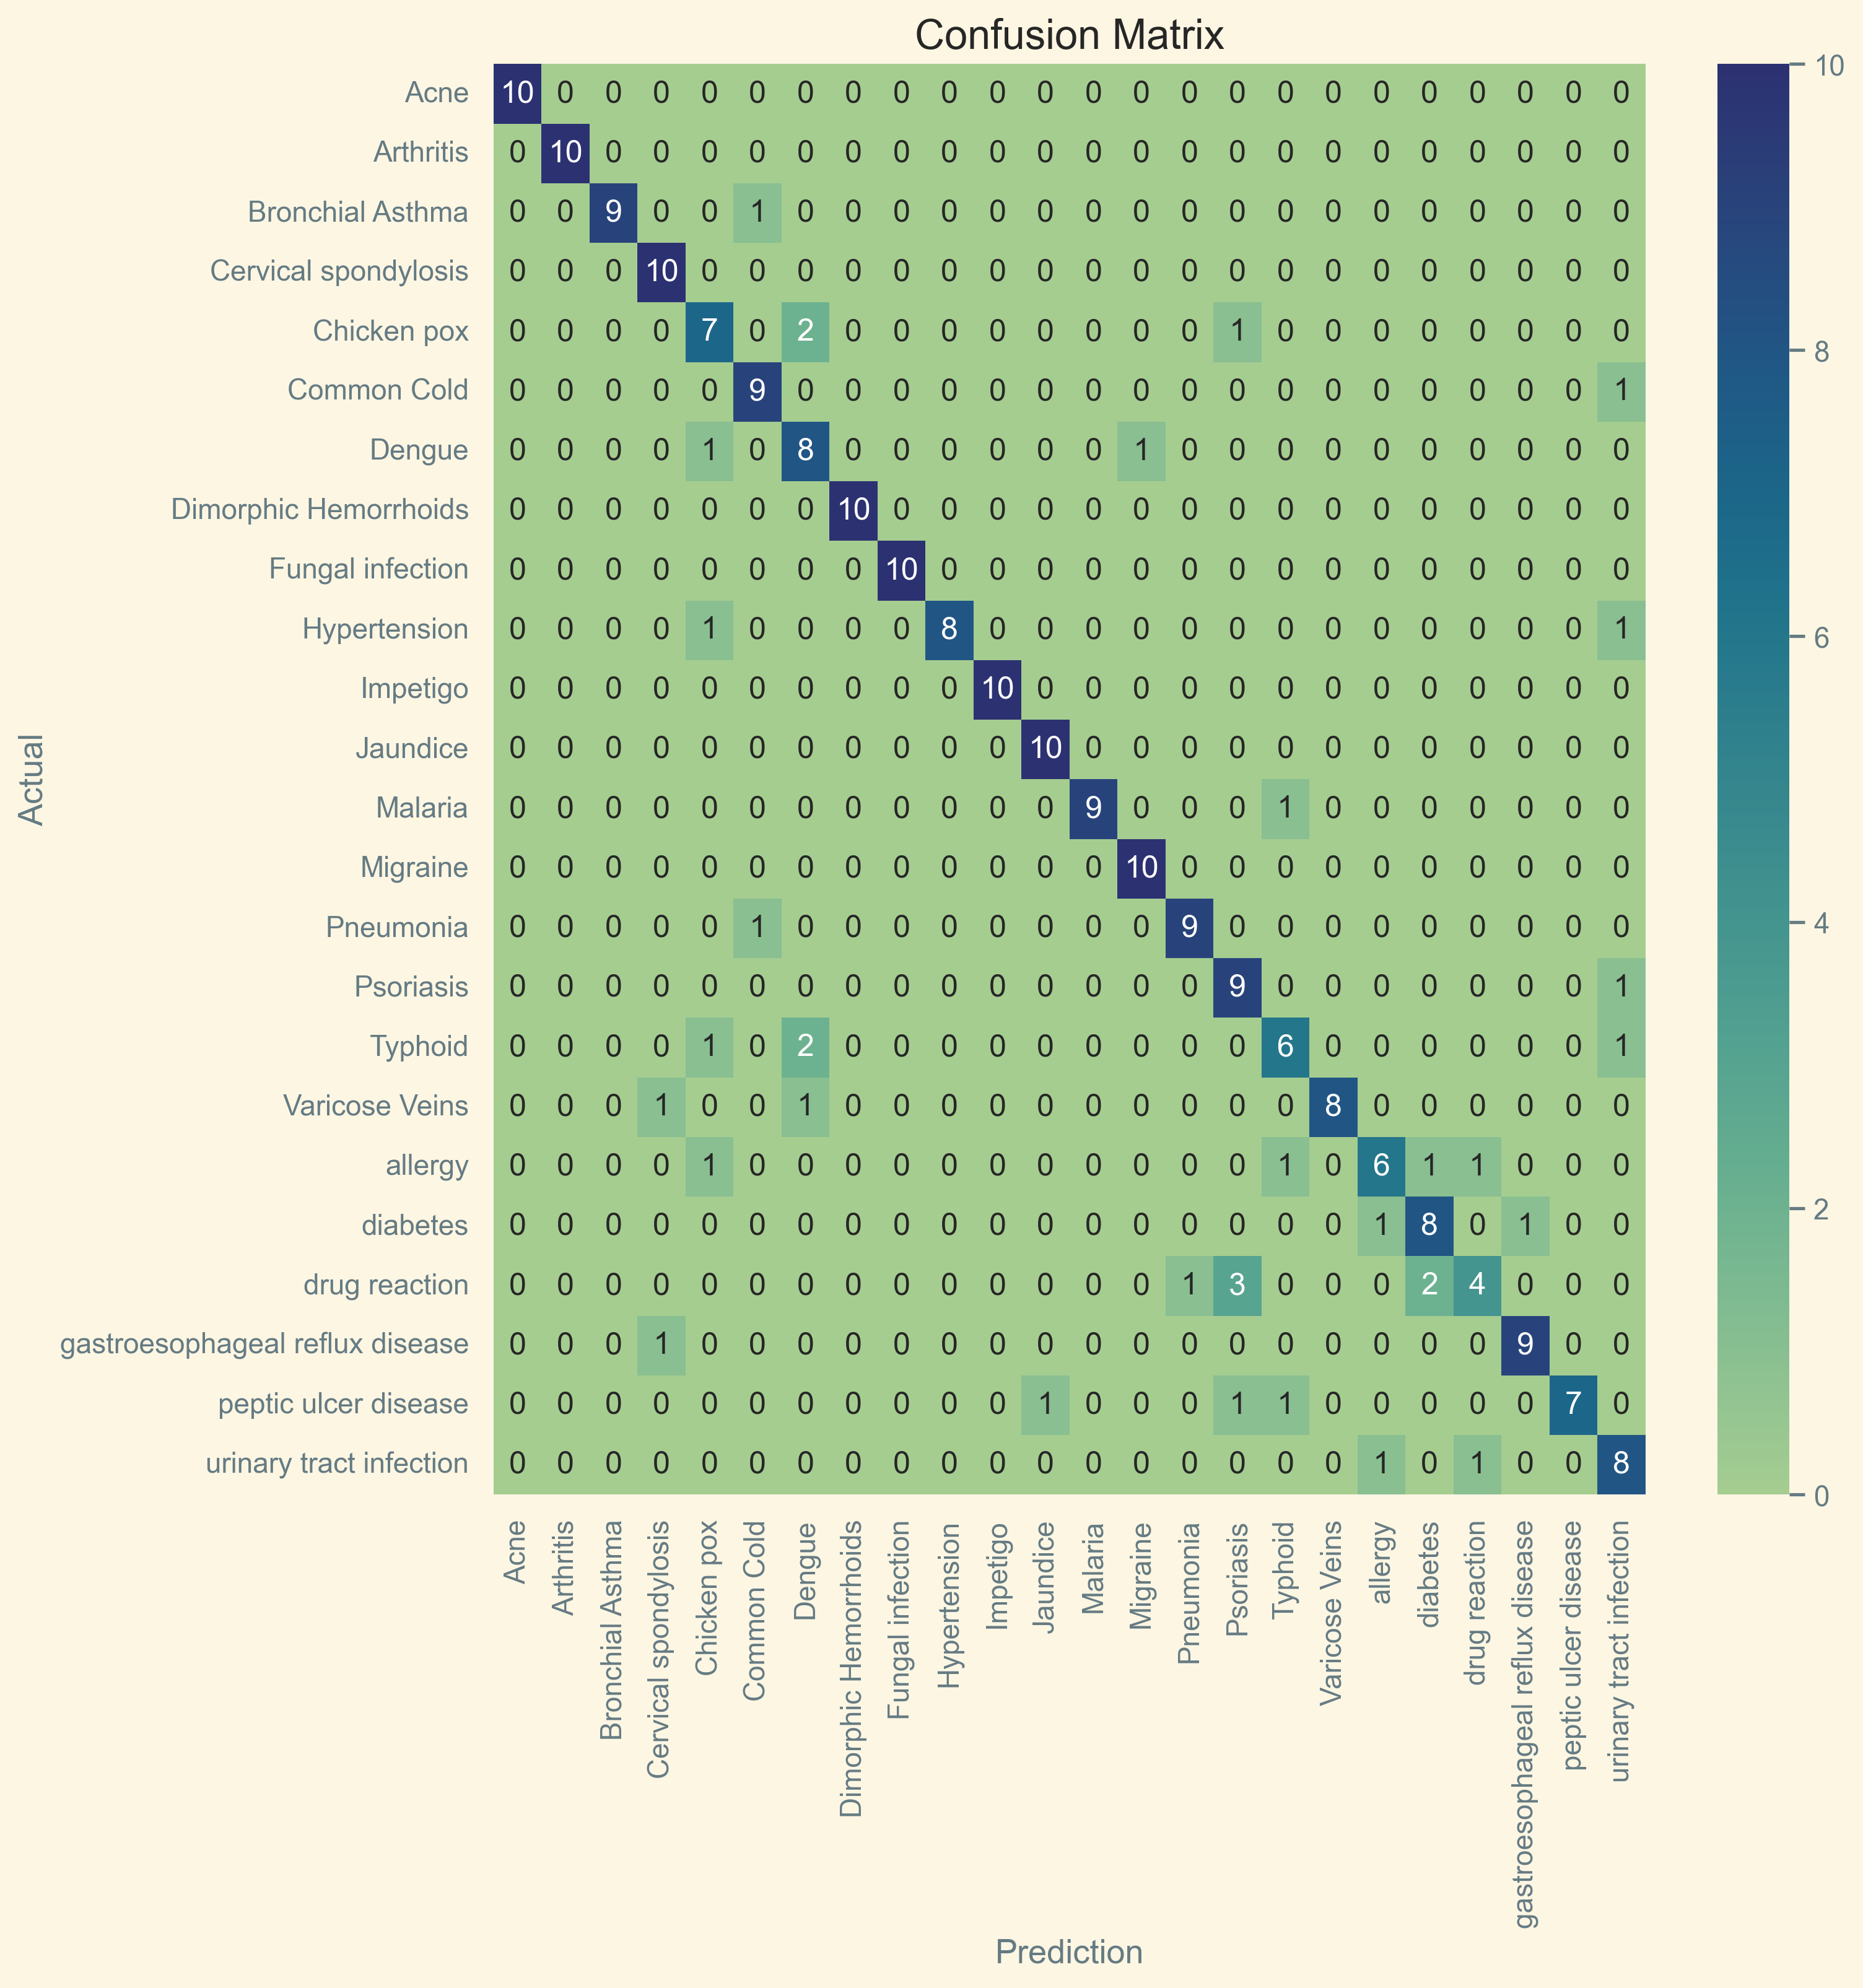

In [113]:
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(1,1, figsize=(10,10), dpi=300)
plot_confusion_matrix(cm, ax, report, class_labels)

## Hyperparameter optimization with nested cross validation
- We will provide our model with different combinations of hyperparameters and test the performance of the model for each of them in a validation set taken by dividing into k different folds our train set
- The hyperparameters we will be considering are:
    - Embedding dimension : the dimension of our embeddings usually around 50 - 300 dimensions
    - Number of units of the BiDirectional LSTM : it is often a good practice to match a higher number of units with a higher embedding dimension as it will be able to extract more important features from our inputs. We will consider 32, 64, 128, 256. Because it is a bi-directional model the number of units it's doubled
    - Learning Rate
    - And the dropout rate of the dropout layer

In [114]:
from sklearn.model_selection import StratifiedKFold
import random

def cross_validation(X_train, Y_train, params, input_shape, batch_size, n_unique_words, num_classes, class_labels, bert=False, bert_model_name=None, attention_mask=None):

    comb = get_params(params)
    if bert:
        random_search = [random.choice(comb) for _ in range(3)] # considering only 5
    else:
        random_search = [random.choice(comb) for _ in range(10)] # considering only 10 random combinations
    inner_split = StratifiedKFold(n_splits=3) # 3 splits as our dataset it's rather small
    models_performance = []
        
    for i, (train_index, val_index) in enumerate(inner_split.split(X_train, Y_train)):
        x_train, x_val = X_train[train_index, :], X_train[val_index, :]
        y_train, y_val = Y_train[train_index], Y_train[val_index]

        if attention_mask is not None:
            attention_train, attention_val = attention_mask[train_index, :], attention_mask[val_index, :]
        
        for comb in random_search:
            embedding_dimension = comb['embedding_dimension']
            n_units = comb['n_units']
            learning_rate = comb['learning_rate']
            dropout_rate = comb['dropout_rate']
            

            if bert and bert_model_name is not None:
                model = model_bert(
                    bert_model_name, input_shape=input_shape, rate=dropout_rate, 
                    num_classes=num_classes, learning_rate=learning_rate, batch_size=batch_size,
                    out_activation='softmax',
                    loss='sparse_categorical_crossentropy')
                print(f"Training fold {i} with parameters:\n"
                      f"Learning Rate: {learning_rate}\n"
                      f"Dropout Rate: {dropout_rate}\n")
                model.fit(
                    x=[x_train, attention_train],
                    y=y_train,
                    batch_size=batch_size,
                    epochs=10
                )

                y_pred = model.predict([x_val, attention_val])
                preds = np.argmax(y_pred, axis=1)
                acc = np.mean([1 if y_val[j] == preds[j] else 0 for j in range(len(preds))])
                
                model_dict = {
                    'model': model,
                    'pred': preds,
                    'accuracy': acc,
                    'hyperparameters': (learning_rate, dropout_rate)}
                model.summary()
                print(f"model's accuracy {acc:.2f}")
                print('-'*10)
            else:
                model = Bi_LSTM(
                    input_shape=input_shape,
                    batch_size=batch_size,
                    n_unique_words=n_unique_words,
                    output_dim=embedding_dimension,
                    num_classes=num_classes,
                    n_units=n_units,
                    rate=dropout_rate)
                
                print(f"Training fold {i} with parameters:\n"
                      f"Embedding Dimension: {embedding_dimension}\n"
                      f"Number of units: {n_units}\n"
                      f"Learning Rate: {learning_rate}\n"
                      f"Dropout Rate: {dropout_rate}\n")
                model.print_summary()
                model.compile(
                    optimizer= tf.optimizers.Adam(learning_rate=learning_rate),
                    loss='sparse_categorical_crossentropy',
                    metrics=[keras.metrics.SparseCategoricalAccuracy()]
                )

                
                history = model.fit(
                    x=x_train,
                    y=y_train,
                    batch_size=batch_size,
                    epochs=30
                )
            
                y_pred = model.predict(x_val)
                preds = np.argmax(y_pred, axis=1)
                acc = np.mean([1 if y_val[j] == preds[j] else 0 for j in range(len(preds))])
                report = class_report(y_val, preds, class_labels)
                
                model_dict = {
                    'model': (model.model, history),
                    'pred': preds,
                    'accuracy': acc,
                    'f1-score': report['weighted avg']['f1-score'],
                    'hyperparameters': (embedding_dimension, n_units, learning_rate, dropout_rate)}

                print(f"model's accuracy {acc:.2f} and model's f1-score {report['weighted avg']['f1-score']:.2f}")
                print('-'*10)
            
            models_performance.append(model_dict)

    if any('f1-score' not in model.keys() for model in models_performance):
        overall_acc = [(model_dict['model'], model_dict['accuracy'], model_dict['hyperparameters']) for model_dict in models_performance]
    else:
        overall_acc = [(model_dict['model'], model_dict['f1-score'], model_dict['hyperparameters']) for model_dict in models_performance]
    
    overall_sort = sorted(overall_acc, key=lambda x: x[1], reverse=True)
    best_model, best_score, best_hyperparameters = overall_sort[0][0], overall_sort[0][1], overall_sort[0][2]
    
    print(f"Best Model: {best_model}\Best score: {best_score}")
    return best_model, best_score, best_hyperparameters

In [115]:
from typing import Dict, List, Any
from itertools import product

params = {
    'embedding_dimension' : [50, 100, 200],
    'n_units' : [32, 64, 128],
    'learning_rate' : np.random.uniform(0.0001, 0.01, size=4),
    'dropout_rate' : np.random.uniform(0.3, 0.6, size=4)
}

def get_params(params : Dict[str, List[any]]):
    all_params = []
    keys = list(params.keys())
    for values in product(*params.values()):
        param_dict = {keys[i]: value for i, value in enumerate(values)}
        all_params.append(param_dict)
    return all_params


In [116]:
best_model, best_score, hyperparameters = cross_validation(X_train, y_train, params, X_clean.shape[1], 32, len(vocab), len(target), class_labels)

Training fold 0 with parameters:
Embedding Dimension: 50
Number of units: 64
Learning Rate: 0.0017863636071425082
Dropout Rate: 0.31031944301420855



Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (32, 33, 50)      │     71,200 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (32, 33)          │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (32, 128)         │     58,880 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (32, 128)         │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (32, 24)          │      3,096 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,176 (520.22 KB)

 Trainable params: 133,176 (520.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.1658 - sparse_categorical_accuracy: 0.1350
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8837 - sparse_categorical_accuracy: 0.5223
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9008 - sparse_categorical_accuracy: 0.5528
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0489 - sparse_categorical_accuracy: 0.7928
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5725 - sparse_categorical_accuracy: 0.9007
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2769 - sparse_categorical_accuracy: 0.9726
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.9819
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0780 - sparse_categorical_accuracy: 0.9962
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0503 - sparse_categorical_accuracy: 0.9989
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0353 - spars

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (32, 33, 100)     │    142,400 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (32, 33)          │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (32, 256)         │    234,496 │ embedding_2[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (32, 256)         │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (32, 24)          │      6,168 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 383,064 (1.46 MB)

 Trainable params: 383,064 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.0185 - sparse_categorical_accuracy: 0.1848
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4392 - sparse_categorical_accuracy: 0.6104
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3939 - sparse_categorical_accuracy: 0.9027
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1975 - sparse_categorical_accuracy: 0.9541
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0982 - sparse_categorical_accuracy: 0.9749
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0696 - sparse_categorical_accuracy: 0.9864
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0519 - sparse_categorical_accuracy: 0.9927
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0096 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0050 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.00

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (32, 33, 200)     │    284,800 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (32, 33)          │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (32, 64)          │     59,648 │ embedding_3[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (32, 64)          │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (32, 24)          │      1,560 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 346,008 (1.32 MB)

 Trainable params: 346,008 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.1357 - sparse_categorical_accuracy: 0.2595 
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5832 - sparse_categorical_accuracy: 0.6908
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5216 - sparse_categorical_accuracy: 0.6478
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8224 - sparse_categorical_accuracy: 0.9162
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3689 - sparse_categorical_accuracy: 0.9788
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1611 - sparse_categorical_accuracy: 0.9980
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0760 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0427 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0302 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.021

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (32, 33, 100)     │    142,400 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (32, 33)          │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (32, 128)         │     84,480 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (32, 128)         │          0 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (32, 24)          │      3,096 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 229,976 (898.34 KB)

 Trainable params: 229,976 (898.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.9268 - sparse_categorical_accuracy: 0.1874
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0875 - sparse_categorical_accuracy: 0.7224
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3258 - sparse_categorical_accuracy: 0.9223
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0946 - sparse_categorical_accuracy: 0.9782
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0494 - sparse_categorical_accuracy: 0.9906
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0189 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (32, 33, 100)     │    142,400 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (32, 33)          │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (32, 64)          │     34,048 │ embedding_5[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (32, 64)          │          0 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (32, 24)          │      1,560 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 178,008 (695.34 KB)

 Trainable params: 178,008 (695.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8964 - sparse_categorical_accuracy: 0.2709
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0770 - sparse_categorical_accuracy: 0.8172
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2160 - sparse_categorical_accuracy: 0.9708
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0428 - sparse_categorical_accuracy: 0.9989
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0146 - sparse_categorical_accuracy: 1.0000
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9957
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - spa

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (32, 33, 200)     │    284,800 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (32, 33)          │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (32, 128)         │    135,680 │ embedding_6[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (32, 128)         │          0 │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (32, 24)          │      3,096 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,576 (1.62 MB)

 Trainable params: 423,576 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.9819 - sparse_categorical_accuracy: 0.3494
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0432 - sparse_categorical_accuracy: 0.7429
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2368 - sparse_categorical_accuracy: 0.9751
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0627 - sparse_categorical_accuracy: 0.9903
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0310 - sparse_categorical_accuracy: 0.9951
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - sparse_categorical_accuracy: 0.9996
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0115 - sparse_categorical_accuracy: 0.9984
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0181 - sparse_categorical_accuracy: 0.9974
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0074

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (32, 33, 200)     │    284,800 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (32, 33)          │          0 │ input_layer_7[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (32, 64)          │     59,648 │ embedding_7[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (32, 64)          │          0 │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (32, 24)          │      1,560 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 346,008 (1.32 MB)

 Trainable params: 346,008 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.8853 - sparse_categorical_accuracy: 0.3210
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8129 - sparse_categorical_accuracy: 0.8630
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.9644
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0455 - sparse_categorical_accuracy: 0.9927
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9955
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - 

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (32, 33, 50)      │     71,200 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_8         │ (32, 33)          │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (32, 128)         │     58,880 │ embedding_8[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (32, 128)         │          0 │ bidirectional_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (32, 24)          │      3,096 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,176 (520.22 KB)

 Trainable params: 133,176 (520.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.1178 - sparse_categorical_accuracy: 0.1132
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0728 - sparse_categorical_accuracy: 0.4030
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9141 - sparse_categorical_accuracy: 0.8002
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3982 - sparse_categorical_accuracy: 0.9230
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.9879
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9932
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0396 - sparse_categorical_accuracy: 0.9921
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0414 - sparse_categorical_accuracy: 0.9895
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0280 - sparse_categorical_accuracy: 0.9969
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0235 - spars

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (32, 33, 50)      │     71,200 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_9         │ (32, 33)          │          0 │ input_layer_9[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (32, 256)         │    183,296 │ embedding_9[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (32, 256)         │          0 │ bidirectional_9[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (32, 24)          │      6,168 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 260,664 (1018.22 KB)

 Trainable params: 260,664 (1018.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.0694 - sparse_categorical_accuracy: 0.1295
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.8083 - sparse_categorical_accuracy: 0.4662
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9133 - sparse_categorical_accuracy: 0.7101
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4648 - sparse_categorical_accuracy: 0.8869
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3670 - sparse_categorical_accuracy: 0.8950
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2062 - sparse_categorical_accuracy: 0.9547
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.9610
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0798 - sparse_categorical_accuracy: 0.9866
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0297 - sparse_categorical_accuracy: 0.9992
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.01

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (32, 33, 100)     │    142,400 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_10        │ (32, 33)          │          0 │ input_layer_10[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (32, 64)          │     34,048 │ embedding_10[0][… │
│ (Bidirectional)     │                   │            │ not_equal_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (32, 64)          │          0 │ bidirectional_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (32, 24)          │      1,560 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 178,008 (695.34 KB)

 Trainable params: 178,008 (695.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.9621 - sparse_categorical_accuracy: 0.1987
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2885 - sparse_categorical_accuracy: 0.7279
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3696 - sparse_categorical_accuracy: 0.9353
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0924 - sparse_categorical_accuracy: 0.9888
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9982
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - spars

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (32, 33, 50)      │     71,200 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_11        │ (32, 33)          │          0 │ input_layer_11[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (32, 128)         │     58,880 │ embedding_11[0][… │
│ (Bidirectional)     │                   │            │ not_equal_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (32, 128)         │          0 │ bidirectional_11… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (32, 24)          │      3,096 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,176 (520.22 KB)

 Trainable params: 133,176 (520.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.1668 - sparse_categorical_accuracy: 0.1568
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8835 - sparse_categorical_accuracy: 0.6034
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8793 - sparse_categorical_accuracy: 0.4622
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0431 - sparse_categorical_accuracy: 0.7698
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4278 - sparse_categorical_accuracy: 0.9484
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.9821
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9901
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0796 - sparse_categorical_accuracy: 0.9887
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0509 - sparse_categorical_accuracy: 0.9918
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0374 - spa

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (32, 33, 100)     │    142,400 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_12        │ (32, 33)          │          0 │ input_layer_12[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (32, 256)         │    234,496 │ embedding_12[0][… │
│ (Bidirectional)     │                   │            │ not_equal_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (32, 256)         │          0 │ bidirectional_12… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (32, 24)          │      6,168 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 383,064 (1.46 MB)

 Trainable params: 383,064 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.0057 - sparse_categorical_accuracy: 0.1628
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2588 - sparse_categorical_accuracy: 0.6052
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4051 - sparse_categorical_accuracy: 0.8926
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2770 - sparse_categorical_accuracy: 0.9127
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0899 - sparse_categorical_accuracy: 0.9757
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0773 - sparse_categorical_accuracy: 0.9831
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0328 - sparse_categorical_accuracy: 0.9961
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0122 - sparse_categorical_accuracy: 0.9995
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9953
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.01

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (32, 33, 200)     │    284,800 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_13        │ (32, 33)          │          0 │ input_layer_13[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_13    │ (32, 64)          │     59,648 │ embedding_13[0][… │
│ (Bidirectional)     │                   │            │ not_equal_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (32, 64)          │          0 │ bidirectional_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (32, 24)          │      1,560 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 346,008 (1.32 MB)

 Trainable params: 346,008 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.1359 - sparse_categorical_accuracy: 0.2564
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6177 - sparse_categorical_accuracy: 0.7359
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6019 - sparse_categorical_accuracy: 0.7009
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7594 - sparse_categorical_accuracy: 0.9509
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3435 - sparse_categorical_accuracy: 0.9897
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1112 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0555 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0327 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0239 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0186 - s

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (32, 33, 100)     │    142,400 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_14        │ (32, 33)          │          0 │ input_layer_14[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_14    │ (32, 128)         │     84,480 │ embedding_14[0][… │
│ (Bidirectional)     │                   │            │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (32, 128)         │          0 │ bidirectional_14… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (32, 24)          │      3,096 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 229,976 (898.34 KB)

 Trainable params: 229,976 (898.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.8736 - sparse_categorical_accuracy: 0.1962
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0913 - sparse_categorical_accuracy: 0.7087
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2497 - sparse_categorical_accuracy: 0.9449
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1220 - sparse_categorical_accuracy: 0.9611
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0333 - sparse_categorical_accuracy: 0.9943
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0176 - sparse_categorical_accuracy: 0.9989
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114 - sparse_categorical_accuracy: 0.9973
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0284 - sparse_categorical_accuracy: 0.9930
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.002

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (32, 33, 100)     │    142,400 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_15        │ (32, 33)          │          0 │ input_layer_15[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_15    │ (32, 64)          │     34,048 │ embedding_15[0][… │
│ (Bidirectional)     │                   │            │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (32, 64)          │          0 │ bidirectional_15… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (32, 24)          │      1,560 │ dropout_16[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 178,008 (695.34 KB)

 Trainable params: 178,008 (695.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.9065 - sparse_categorical_accuracy: 0.2823
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9088 - sparse_categorical_accuracy: 0.8244
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.9818
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0292 - sparse_categorical_accuracy: 0.9996
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0159 - sparse_categorical_accuracy: 1.0000
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0073 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.002

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (32, 33, 200)     │    284,800 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_16        │ (32, 33)          │          0 │ input_layer_16[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_16    │ (32, 128)         │    135,680 │ embedding_16[0][… │
│ (Bidirectional)     │                   │            │ not_equal_16[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (32, 128)         │          0 │ bidirectional_16… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (32, 24)          │      3,096 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,576 (1.62 MB)

 Trainable params: 423,576 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.9782 - sparse_categorical_accuracy: 0.2614
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1669 - sparse_categorical_accuracy: 0.7518
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2443 - sparse_categorical_accuracy: 0.9666
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9962
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0303 - sparse_categorical_accuracy: 0.9966
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0102 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.002

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (32, 33, 200)     │    284,800 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_17        │ (32, 33)          │          0 │ input_layer_17[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_17    │ (32, 64)          │     59,648 │ embedding_17[0][… │
│ (Bidirectional)     │                   │            │ not_equal_17[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (32, 64)          │          0 │ bidirectional_17… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (32, 24)          │      1,560 │ dropout_18[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 346,008 (1.32 MB)

 Trainable params: 346,008 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.8725 - sparse_categorical_accuracy: 0.3820
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7778 - sparse_categorical_accuracy: 0.8705
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0981 - sparse_categorical_accuracy: 0.9948
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0236 - sparse_categorical_accuracy: 0.9977
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0118 - sparse_categorical_accuracy: 1.0000
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_18        │ (32, 33, 50)      │     71,200 │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_18        │ (32, 33)          │          0 │ input_layer_18[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_18    │ (32, 128)         │     58,880 │ embedding_18[0][… │
│ (Bidirectional)     │                   │            │ not_equal_18[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (32, 128)         │          0 │ bidirectional_18… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (32, 24)          │      3,096 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,176 (520.22 KB)

 Trainable params: 133,176 (520.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.1049 - sparse_categorical_accuracy: 0.1609
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9473 - sparse_categorical_accuracy: 0.4274
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8623 - sparse_categorical_accuracy: 0.7767
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3867 - sparse_categorical_accuracy: 0.9074
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2118 - sparse_categorical_accuracy: 0.9490
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1504 - sparse_categorical_accuracy: 0.9696
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0691 - sparse_categorical_accuracy: 0.9883
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0283 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0123 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088 

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (32, 33, 50)      │     71,200 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_19        │ (32, 33)          │          0 │ input_layer_19[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_19    │ (32, 256)         │    183,296 │ embedding_19[0][… │
│ (Bidirectional)     │                   │            │ not_equal_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (32, 256)         │          0 │ bidirectional_19… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (32, 24)          │      6,168 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 260,664 (1018.22 KB)

 Trainable params: 260,664 (1018.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.0892 - sparse_categorical_accuracy: 0.1592
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6401 - sparse_categorical_accuracy: 0.4675
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8999 - sparse_categorical_accuracy: 0.7125
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4810 - sparse_categorical_accuracy: 0.8662
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2800 - sparse_categorical_accuracy: 0.9183
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2662 - sparse_categorical_accuracy: 0.9251
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1500 - sparse_categorical_accuracy: 0.9518
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0819 - sparse_categorical_accuracy: 0.9809
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0617 - sparse_categorical_accuracy: 0.9898
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.03

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_20        │ (32, 33, 100)     │    142,400 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_20        │ (32, 33)          │          0 │ input_layer_20[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_20    │ (32, 64)          │     34,048 │ embedding_20[0][… │
│ (Bidirectional)     │                   │            │ not_equal_20[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (32, 64)          │          0 │ bidirectional_20… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (32, 24)          │      1,560 │ dropout_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 178,008 (695.34 KB)

 Trainable params: 178,008 (695.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.9475 - sparse_categorical_accuracy: 0.2709 
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0918 - sparse_categorical_accuracy: 0.7318
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3058 - sparse_categorical_accuracy: 0.9640
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0712 - sparse_categorical_accuracy: 0.9930
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0417 - sparse_categorical_accuracy: 0.9935
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0124 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0048 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 -

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_21        │ (32, 33, 50)      │     71,200 │ input_layer_21[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_21        │ (32, 33)          │          0 │ input_layer_21[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_21    │ (32, 128)         │     58,880 │ embedding_21[0][… │
│ (Bidirectional)     │                   │            │ not_equal_21[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (32, 128)         │          0 │ bidirectional_21… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (32, 24)          │      3,096 │ dropout_22[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,176 (520.22 KB)

 Trainable params: 133,176 (520.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.1646 - sparse_categorical_accuracy: 0.1206
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8356 - sparse_categorical_accuracy: 0.4859
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7224 - sparse_categorical_accuracy: 0.5552
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0694 - sparse_categorical_accuracy: 0.7385
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5498 - sparse_categorical_accuracy: 0.8819
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3224 - sparse_categorical_accuracy: 0.9512
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1726 - sparse_categorical_accuracy: 0.9715
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9900
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0531 - sparse_categorical_accuracy: 0.9986
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.03

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (32, 33, 100)     │    142,400 │ input_layer_22[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_22        │ (32, 33)          │          0 │ input_layer_22[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_22    │ (32, 256)         │    234,496 │ embedding_22[0][… │
│ (Bidirectional)     │                   │            │ not_equal_22[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (32, 256)         │          0 │ bidirectional_22… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (32, 24)          │      6,168 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 383,064 (1.46 MB)

 Trainable params: 383,064 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.0214 - sparse_categorical_accuracy: 0.1845
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4451 - sparse_categorical_accuracy: 0.5715
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5270 - sparse_categorical_accuracy: 0.8500
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2046 - sparse_categorical_accuracy: 0.9537
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2118 - sparse_categorical_accuracy: 0.9396
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1718 - sparse_categorical_accuracy: 0.9575
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0884 - sparse_categorical_accuracy: 0.9724
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0710 - sparse_categorical_accuracy: 0.9852
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0152 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.00

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_23        │ (32, 33, 200)     │    284,800 │ input_layer_23[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_23        │ (32, 33)          │          0 │ input_layer_23[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_23    │ (32, 64)          │     59,648 │ embedding_23[0][… │
│ (Bidirectional)     │                   │            │ not_equal_23[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (32, 64)          │          0 │ bidirectional_23… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (32, 24)          │      1,560 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 346,008 (1.32 MB)

 Trainable params: 346,008 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.1402 - sparse_categorical_accuracy: 0.2165 
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6301 - sparse_categorical_accuracy: 0.7365
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5111 - sparse_categorical_accuracy: 0.7474
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7593 - sparse_categorical_accuracy: 0.9613
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3119 - sparse_categorical_accuracy: 0.9909
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.9977
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0565 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0341 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0220 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0182 - spar

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_24        │ (32, 33, 100)     │    142,400 │ input_layer_24[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_24        │ (32, 33)          │          0 │ input_layer_24[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_24    │ (32, 128)         │     84,480 │ embedding_24[0][… │
│ (Bidirectional)     │                   │            │ not_equal_24[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (32, 128)         │          0 │ bidirectional_24… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (32, 24)          │      3,096 │ dropout_25[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 229,976 (898.34 KB)

 Trainable params: 229,976 (898.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.8769 - sparse_categorical_accuracy: 0.2450
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9754 - sparse_categorical_accuracy: 0.7484
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3273 - sparse_categorical_accuracy: 0.9123
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0894 - sparse_categorical_accuracy: 0.9829
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.9688
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0464 - sparse_categorical_accuracy: 0.9914
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - sparse_categorical_accuracy: 0.9996
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - sp

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_25        │ (32, 33, 100)     │    142,400 │ input_layer_25[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_25        │ (32, 33)          │          0 │ input_layer_25[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_25    │ (32, 64)          │     34,048 │ embedding_25[0][… │
│ (Bidirectional)     │                   │            │ not_equal_25[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (32, 64)          │          0 │ bidirectional_25… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (32, 24)          │      1,560 │ dropout_26[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 178,008 (695.34 KB)

 Trainable params: 178,008 (695.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.9205 - sparse_categorical_accuracy: 0.2896
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0292 - sparse_categorical_accuracy: 0.8066
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1907 - sparse_categorical_accuracy: 0.9739
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0592 - sparse_categorical_accuracy: 0.9895
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0154 - sparse_categorical_accuracy: 1.0000
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - spar

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_26        │ (32, 33, 200)     │    284,800 │ input_layer_26[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_26        │ (32, 33)          │          0 │ input_layer_26[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_26    │ (32, 128)         │    135,680 │ embedding_26[0][… │
│ (Bidirectional)     │                   │            │ not_equal_26[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (32, 128)         │          0 │ bidirectional_26… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (32, 24)          │      3,096 │ dropout_27[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,576 (1.62 MB)

 Trainable params: 423,576 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.9791 - sparse_categorical_accuracy: 0.2789
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2433 - sparse_categorical_accuracy: 0.6817
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2876 - sparse_categorical_accuracy: 0.9568
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.9747
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0339 - sparse_categorical_accuracy: 0.9986
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0107 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.00

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_27        │ (32, 33, 200)     │    284,800 │ input_layer_27[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_27        │ (32, 33)          │          0 │ input_layer_27[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_27    │ (32, 64)          │     59,648 │ embedding_27[0][… │
│ (Bidirectional)     │                   │            │ not_equal_27[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (32, 64)          │          0 │ bidirectional_27… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (32, 24)          │      1,560 │ dropout_28[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 346,008 (1.32 MB)

 Trainable params: 346,008 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.8504 - sparse_categorical_accuracy: 0.3994
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.9115
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0686 - sparse_categorical_accuracy: 0.9999
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0202 - sparse_categorical_accuracy: 1.0000
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - sparse_categorical_accuracy: 1.0000
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - spars

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_28        │ (32, 33, 50)      │     71,200 │ input_layer_28[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_28        │ (32, 33)          │          0 │ input_layer_28[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_28    │ (32, 128)         │     58,880 │ embedding_28[0][… │
│ (Bidirectional)     │                   │            │ not_equal_28[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (32, 128)         │          0 │ bidirectional_28… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (32, 24)          │      3,096 │ dropout_29[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,176 (520.22 KB)

 Trainable params: 133,176 (520.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.1105 - sparse_categorical_accuracy: 0.1584 
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9687 - sparse_categorical_accuracy: 0.3717
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0442 - sparse_categorical_accuracy: 0.7299
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3935 - sparse_categorical_accuracy: 0.9452
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1756 - sparse_categorical_accuracy: 0.9624
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1712 - sparse_categorical_accuracy: 0.9511
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0798 - sparse_categorical_accuracy: 0.9926
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0226 - sparse_categorical_accuracy: 0.9997
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0160 - sparse_categorical_accuracy: 0.9984
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072 

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_29        │ (32, 33, 50)      │     71,200 │ input_layer_29[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_29        │ (32, 33)          │          0 │ input_layer_29[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_29    │ (32, 256)         │    183,296 │ embedding_29[0][… │
│ (Bidirectional)     │                   │            │ not_equal_29[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (32, 256)         │          0 │ bidirectional_29… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (32, 24)          │      6,168 │ dropout_30[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 260,664 (1018.22 KB)

 Trainable params: 260,664 (1018.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.0790 - sparse_categorical_accuracy: 0.1122
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6631 - sparse_categorical_accuracy: 0.4740
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8750 - sparse_categorical_accuracy: 0.7311
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5413 - sparse_categorical_accuracy: 0.8328
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3040 - sparse_categorical_accuracy: 0.9054
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2293 - sparse_categorical_accuracy: 0.9369
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2739 - sparse_categorical_accuracy: 0.9201
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1720 - sparse_categorical_accuracy: 0.9604
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0965 - sparse_categorical_accuracy: 0.9801
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.03

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_30        │ (32, 33, 100)     │    142,400 │ input_layer_30[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_30        │ (32, 33)          │          0 │ input_layer_30[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_30    │ (32, 64)          │     34,048 │ embedding_30[0][… │
│ (Bidirectional)     │                   │            │ not_equal_30[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (32, 64)          │          0 │ bidirectional_30… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (32, 24)          │      1,560 │ dropout_31[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 178,008 (695.34 KB)

 Trainable params: 178,008 (695.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.9750 - sparse_categorical_accuracy: 0.1666
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1837 - sparse_categorical_accuracy: 0.7714
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4478 - sparse_categorical_accuracy: 0.8903
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1202 - sparse_categorical_accuracy: 0.9909
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0274 - sparse_categorical_accuracy: 1.0000
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - sparse_categorical_accuracy: 1.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - sparse_categorical_accuracy: 1.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - sparse_categorical_accuracy: 1.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - sparse_categorical_accuracy: 1.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - spars

### Learning Curve of the best model

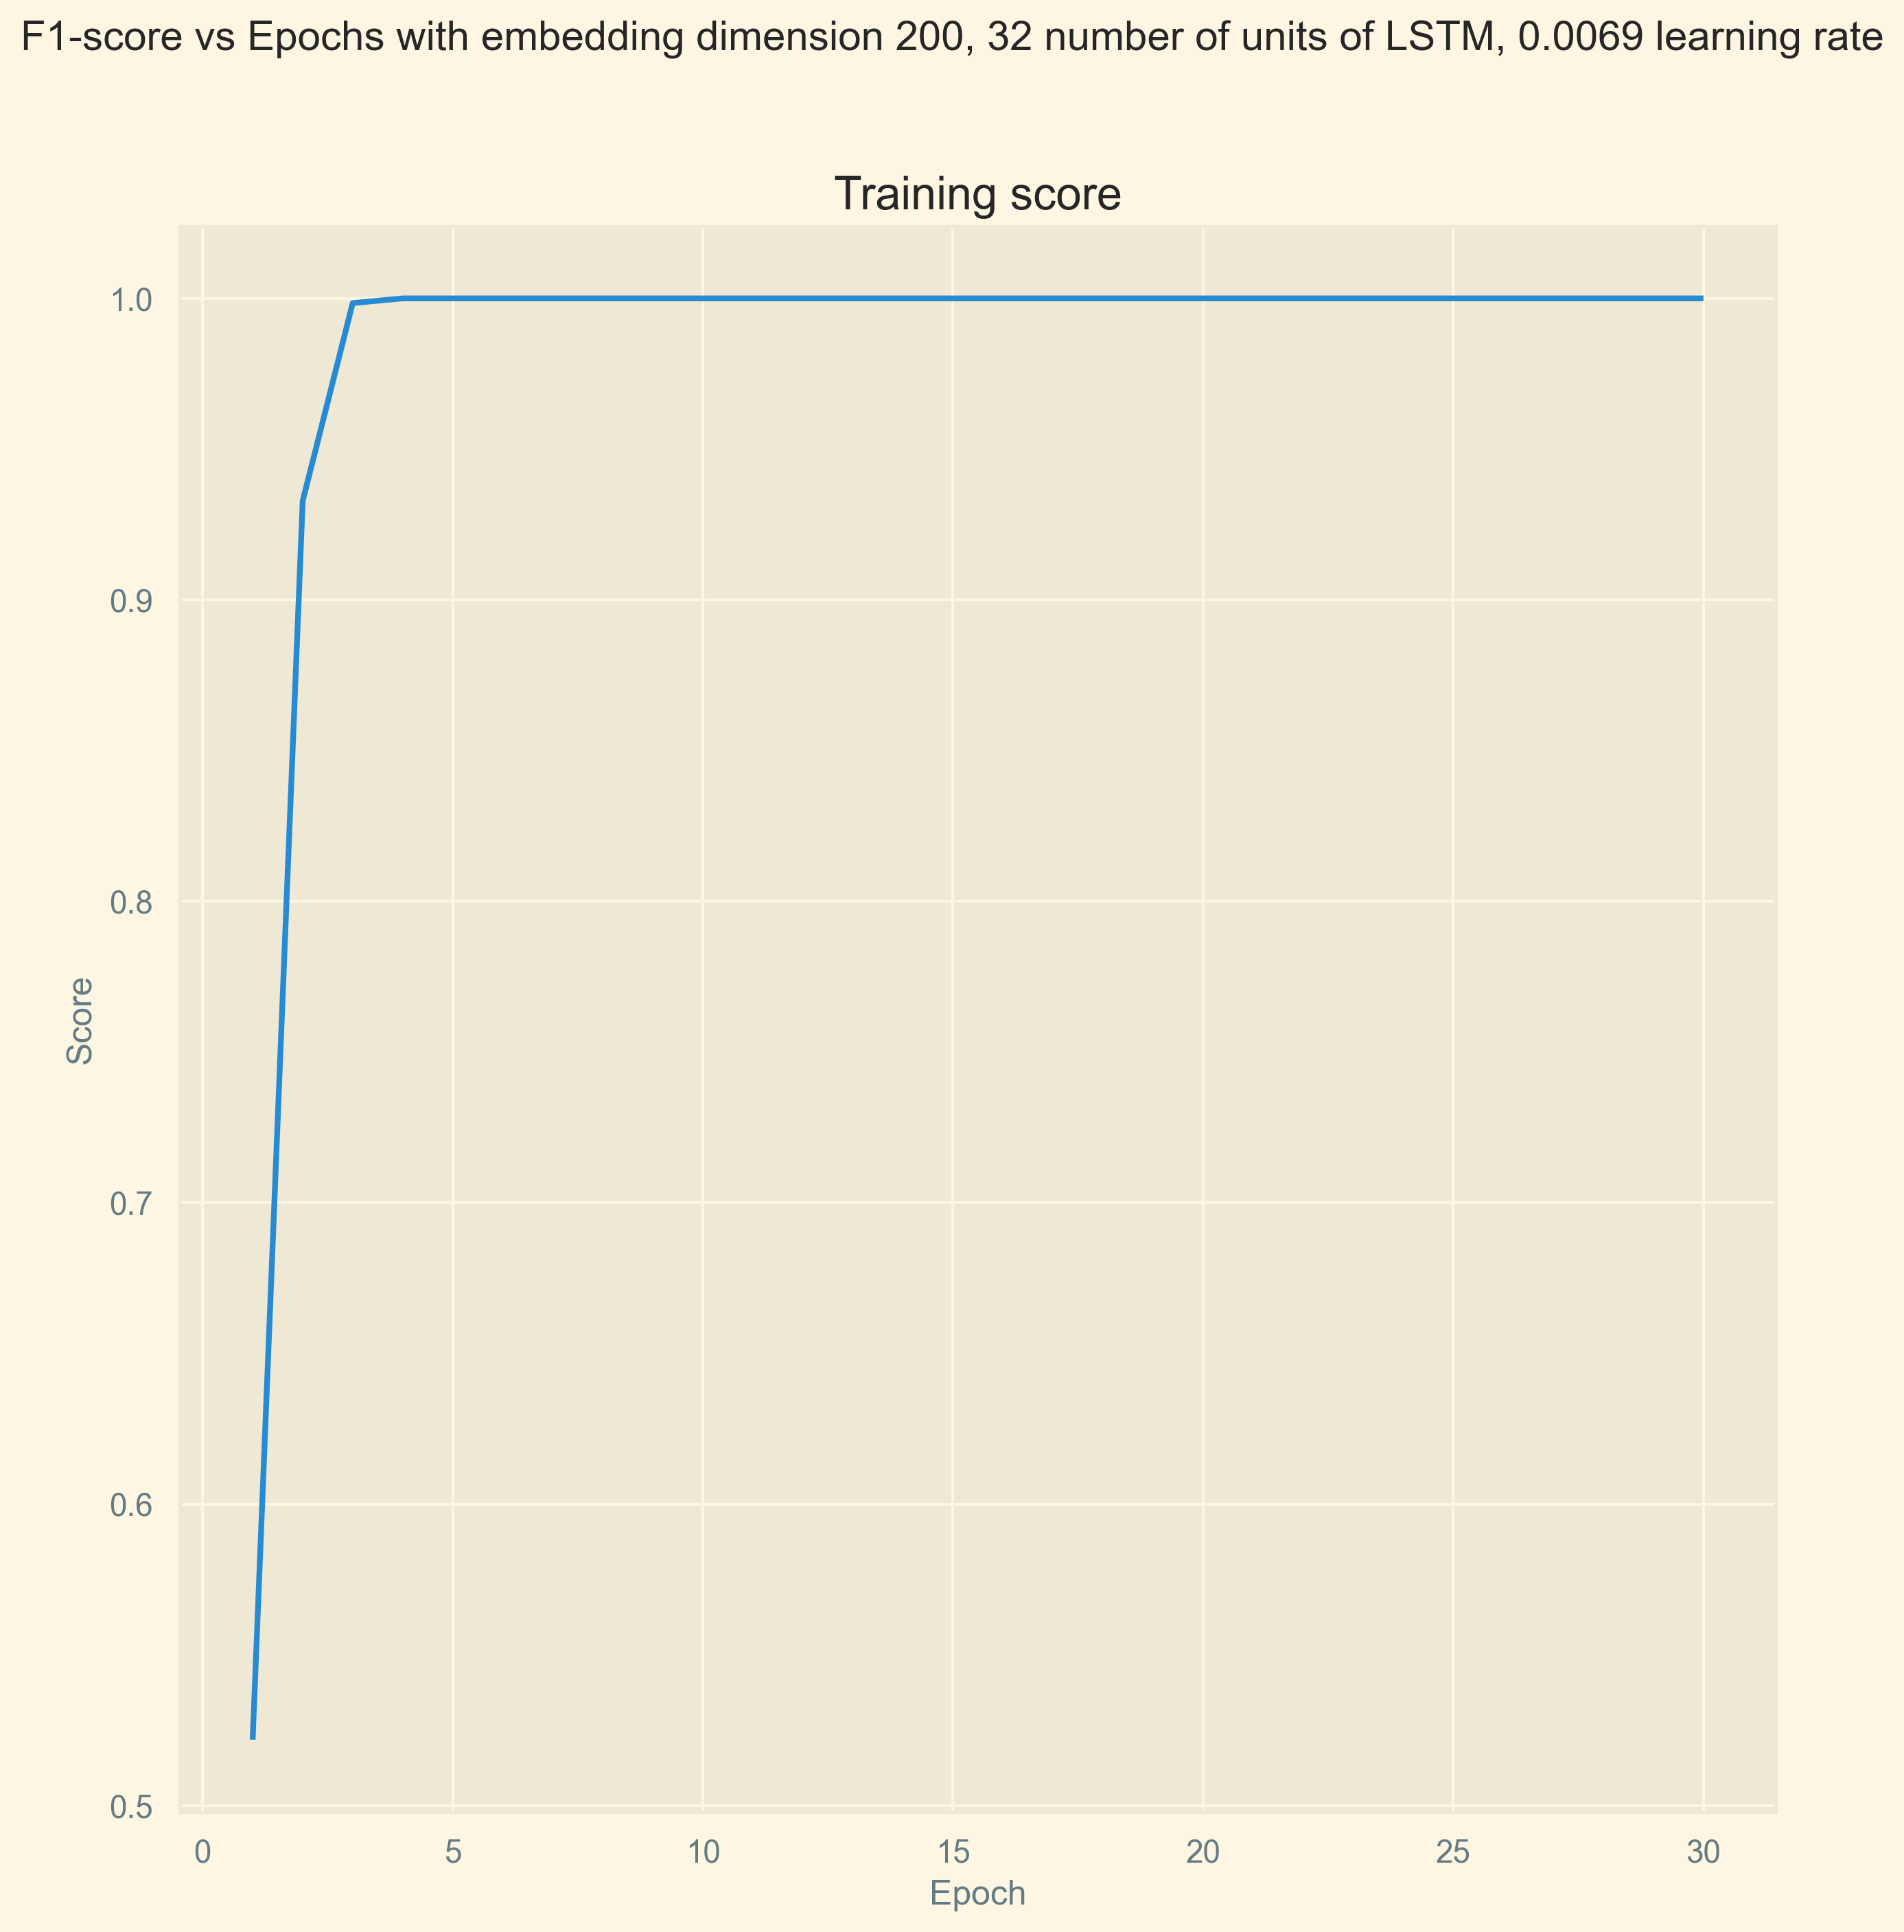

In [117]:
history_model = best_model[1]
emb_dim, n_units, lr, best_rate = hyperparameters
fig, ax = plt.subplots(1,1, figsize=(10,10), dpi=300)
plot_score_epochs(fig, ax, history_model, emb_dim, n_units, lr)

In [221]:
hyperparameters

(200, 32, 0.006860548790690411, 0.46132499448222186)

#### Generalization with unseen data : Predictions on the test set with the best model

In [119]:
best_preds = np.argmax(best_model[0].predict(X_test), axis=1)
best_acc = np.mean([1 if y_test[i] == best_preds[i] else 0 for i in range(len(best_preds))])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [120]:
best_report = class_report(y_true=y_test, y_pred=best_preds, class_labels=class_labels)
best_report.to_csv('Best_LSTM.csv', index=True)
best_report

Acne  Arthritis  Bronchial Asthma  Cervical spondylosis  \
precision   1.0        1.0               1.0                   1.0   
recall      1.0        1.0               1.0                   1.0   
f1-score    1.0        1.0               1.0                   1.0   
support    10.0       10.0              10.0                  10.0   

           Chicken pox  Common Cold     Dengue  Dimorphic Hemorrhoids  \
precision     0.818182     0.909091   0.888889                    1.0   
recall        0.900000     1.000000   0.800000                    1.0   
f1-score      0.857143     0.952381   0.842105                    1.0   
support      10.000000    10.000000  10.000000                   10.0   

           Fungal infection  Hypertension  ...  Varicose Veins    allergy  \
precision               1.0           1.0  ...             0.9   0.909091   
recall                  1.0           1.0  ...             0.9   1.000000   
f1-score                1.0           1.0  ...             0.9   0.952381   
support                10.0          10.0  ...            10.0  10.000000   

            diabetes  drug reaction  gastroesophageal reflux disease  \
precision   0.818182       1.000000                         0.909091   
recall      0.900000       0.400000                         1.000000   
f1-score    0.857143       0.571429                         0.952381   
support    10.000000      10.000000                        10.000000   

           peptic ulcer disease  urinary tract infection  accuracy  \
precision              1.000000                      1.0    0.9375   
recall                 0.900000                      1.0    0.9375   
f1-score               0.947368                      1.0    0.9375   
support               10.000000                     10.0    0.9375   

            macro avg  weighted avg  
precision    0.943710      0.943710  
recall       0.937500      0.937500  
f1-score     0.933346      0.933346  
support    240.000000    240.000000  

[4 rows x 27 columns]

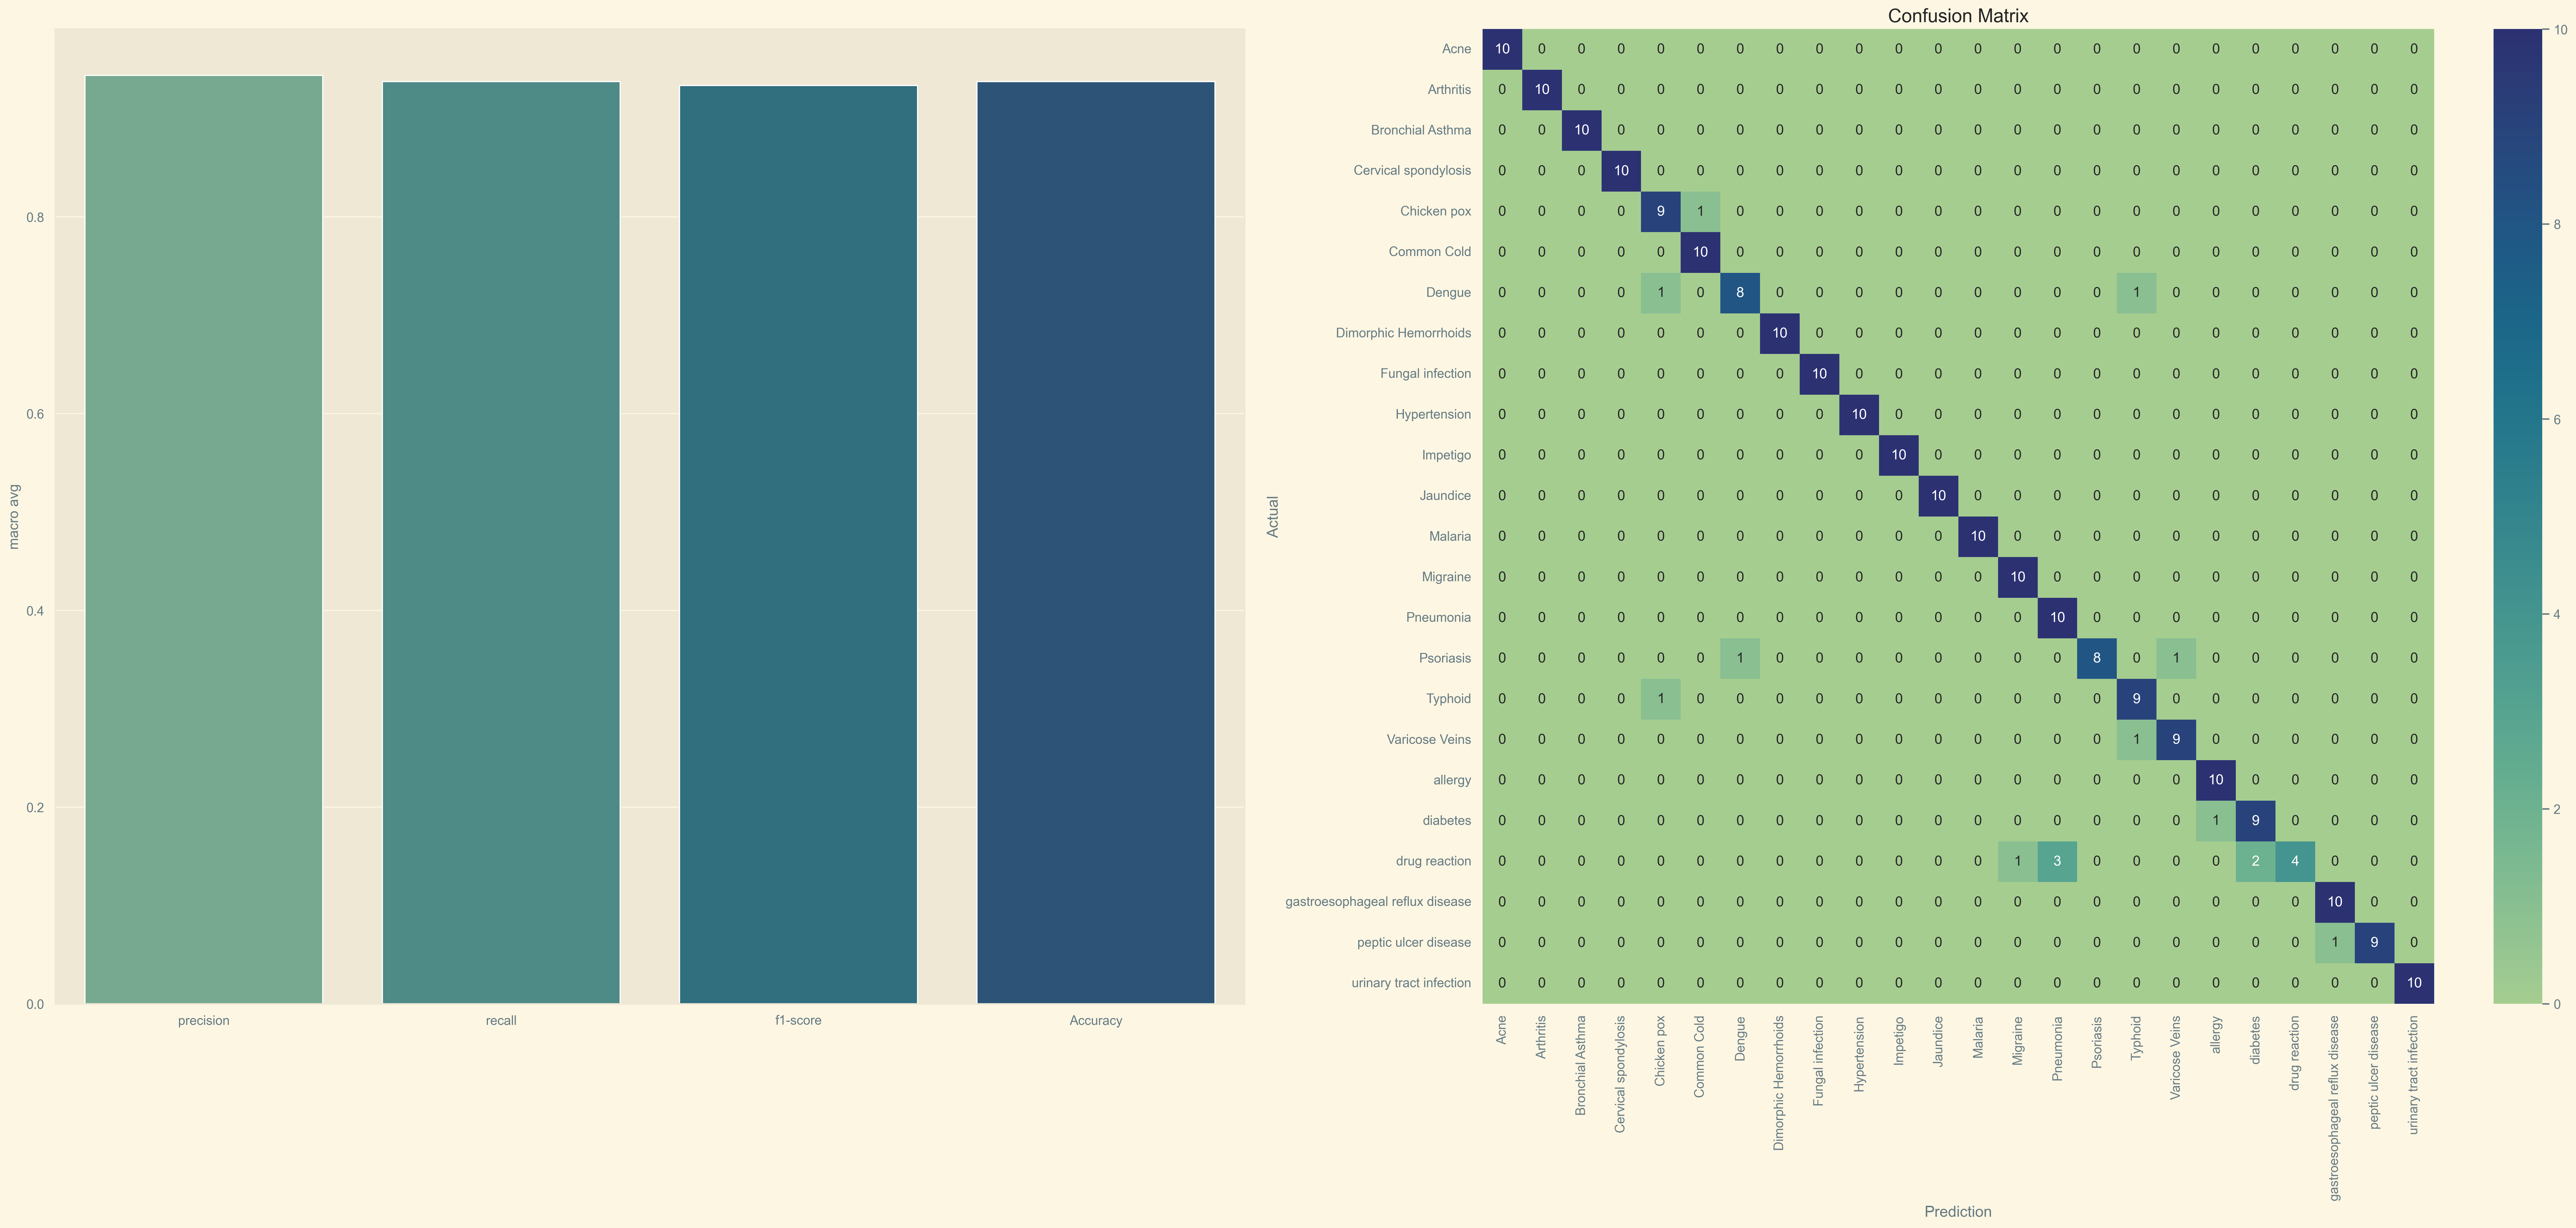

In [225]:
metrics_LSTM = best_report['macro avg'].drop(labels='support', axis=0)
metrics_LSTM.loc['Accuracy'] = best_acc 
cm_best  = confusion_matrix(y_test, best_preds)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(40,15), dpi=300)
sns.barplot(metrics_LSTM, ax=ax1, palette='crest')
plot_confusion_matrix(cm_best, ax2, best_report, class_labels)
fig.savefig('best_LSTM.png')

In [122]:
best_model[0].save('best_LSTM.keras')

## Testing the model with an addittional attention layer
Using the best hyperparameters found during the cross-validation, we will use them with a model that uses attention 

In [123]:
class Attention(tf.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        # number of units 32
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
 
    def call(self, features, hidden):
        '''Computes attention. Note: This function doe'''
        # features shape = (32, 33, 256)
        # hidden shape == (32, 256)

        values = self.W1(features) # Linear projection -> Projecting 256 into 32 dimensions (32, 33, 32)
        query = self.W2(hidden) # Same
        query_with_time_axis = tensorflow.expand_dims(query, 1) # Adding one dimension to compute the sum (32, 1, 32)

        # score shape = (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units) the relevance score across the n_unit dimension for each time step
        score = tensorflow.nn.tanh(
            values + query_with_time_axis)
        attention_weights = tensorflow.nn.softmax(self.V(score), axis=1) # Applying self.V to score we project the 256-dimensional output of the scores to a single scalar value for each time step
        # Softmax it's applied along the max_lenght dimension, in our case 33 (each time step)
        
        # attention_weights shape == (batch_size, max_length, 1)

        context_vector = attention_weights * features # weighted sum of our attention weights (weights) and the features
        context_vector = tensorflow.reduce_sum(context_vector, axis=1) # final output (33, 256)
 
        return context_vector, attention_weights

In [146]:
class Bi_LSTM_Attention(tf.Model):
    def __init__(self, input_shape: int, batch_size: int, n_unique_words: int, output_dim: int, num_classes: int, n_units: int, rate : float, activation='softmax', model=None):
        super(Bi_LSTM_Attention, self).__init__()
        self.model = self.create_model(
            input_shape, 
            batch_size, 
            n_unique_words, 
            output_dim, 
            num_classes,
            n_units,
            rate,
            activation
        )
        self.output_dim = output_dim
        self.n_units = n_units

    @staticmethod
    def create_model(input_shape: int, batch_size: int, n_unique_words: int, output_dim: int, num_classes: int, n_units: int, rate : float, activation: str):
        '''Creates a Bi-Directional LSTM with attention'''
        # Input it's a (batch_size, len(sentence) = 33)
        # First an embedding layer
        inputs = layers.Input(shape=(input_shape,), batch_size=batch_size)
        # masked_inputs = Masking(mask_value=0)(inputs)
        emb = layers.Embedding(
            input_dim=n_unique_words + 1,
            output_dim=output_dim,
            mask_zero=True
        )(inputs)
        
        (bi_lstm, forward_h, forward_c, backward_h, backward_c) = layers.Bidirectional(
            layers.LSTM(n_units, return_sequences=True, return_state=True))(emb)
        
        state_h = layers.Concatenate()([forward_h, backward_h])
        # state_h = layers.Reshape((1, n_units * 2))(state_h)
        
        context_vector, attention_weights = Attention(32)(bi_lstm, state_h)
        x = layers.Dense(64, activation='relu')(context_vector)
        dropout = layers.Dropout(rate)(x)
        output = layers.Dense(num_classes, activation=activation)(dropout)
        model = Model(inputs, [output, attention_weights], name='BiLSTM')
        return model
    
    def call(self, inputs):
        return self.model(inputs)


In [147]:
model2 = Bi_LSTM_Attention(
    input_shape=X_clean.shape[1], 
    batch_size=32, 
    n_unique_words=len(vocab), 
    output_dim=emb_dim, 
    num_classes=len(target),
    n_units=n_units,
    rate=best_rate
)

In [148]:
model2.model.summary()

Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (32, 33)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_33        │ (32, 33, 200)     │    284,800 │ input_layer_33[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_33        │ (32, 33)          │          0 │ input_layer_33[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_33    │ [(32, 33, 64),    │     59,648 │ embedding_33[0][… │
│ (Bidirectional)     │ (32, 32), (32,    │            │ not_equal_33[0][… │
│                     │ 32), (32, 32),    │            │                   │
│                     │ (32, 32)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (32, 64)          │          0 │ bidirectional_33… │
│ (Concatenate)       │                   │            │ bidirectional_33… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ [(32, 64), (32,   │      4,193 │ bidirectional_33… │
│ (Attention)         │ 33, 1)]           │            │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (32, 64)          │      4,160 │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (32, 64)          │          0 │ dense_45[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (32, 24)          │      1,560 │ dropout_34[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 354,361 (1.35 MB)

 Trainable params: 354,361 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [149]:
model2.compile(
    optimizer= tf.optimizers.Adam(learning_rate=lr),
    loss='sparse_categorical_crossentropy'
)
model2.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=30,
    #validation_data=(X_test, y_test)
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 2.8191
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.5322
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0736
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0154
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0031
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0016
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 9.6315e-04
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 7.4534e-04
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 6.2374e-04
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 5.3252e-04
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.2651e-04
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.6914e-04
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.0948e-04
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.9441e-04
Epoch 15/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 

In [150]:
att, attention_weights = model2.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


In [151]:
att_preds = np.argmax(att, axis=1)
att_acc = np.mean([1 if y_test[i] == preds[i] else 0 for i in range(len(preds))])
att_acc

0.85

In [167]:
att_report = class_report(y_true=y_test, y_pred=att_preds, class_labels=class_labels)
att_report.to_csv('Attention.csv', index=True)
att_report

Acne  Arthritis  Bronchial Asthma  Cervical spondylosis  \
precision   1.0        1.0          0.909091                   1.0   
recall      1.0        1.0          1.000000                   1.0   
f1-score    1.0        1.0          0.952381                   1.0   
support    10.0       10.0         10.000000                  10.0   

           Chicken pox  Common Cold  Dengue  Dimorphic Hemorrhoids  \
precision          0.9     0.909091     0.9                    1.0   
recall             0.9     1.000000     0.9                    1.0   
f1-score           0.9     0.952381     0.9                    1.0   
support           10.0    10.000000    10.0                   10.0   

           Fungal infection  Hypertension  ...  Varicose Veins    allergy  \
precision               1.0           1.0  ...        0.909091   1.000000   
recall                  1.0           1.0  ...        1.000000   0.900000   
f1-score                1.0           1.0  ...        0.952381   0.947368   
support                10.0          10.0  ...       10.000000  10.000000   

            diabetes  drug reaction  gastroesophageal reflux disease  \
precision   0.692308       1.000000                         0.909091   
recall      0.900000       0.500000                         1.000000   
f1-score    0.782609       0.666667                         0.952381   
support    10.000000      10.000000                        10.000000   

           peptic ulcer disease  urinary tract infection  accuracy  \
precision              1.000000                 1.000000  0.945833   
recall                 0.900000                 0.900000  0.945833   
f1-score               0.947368                 0.947368  0.945833   
support               10.000000                10.000000  0.945833   

            macro avg  weighted avg  
precision    0.951952      0.951952  
recall       0.945833      0.945833  
f1-score     0.943876      0.943876  
support    240.000000    240.000000  

[4 rows x 27 columns]

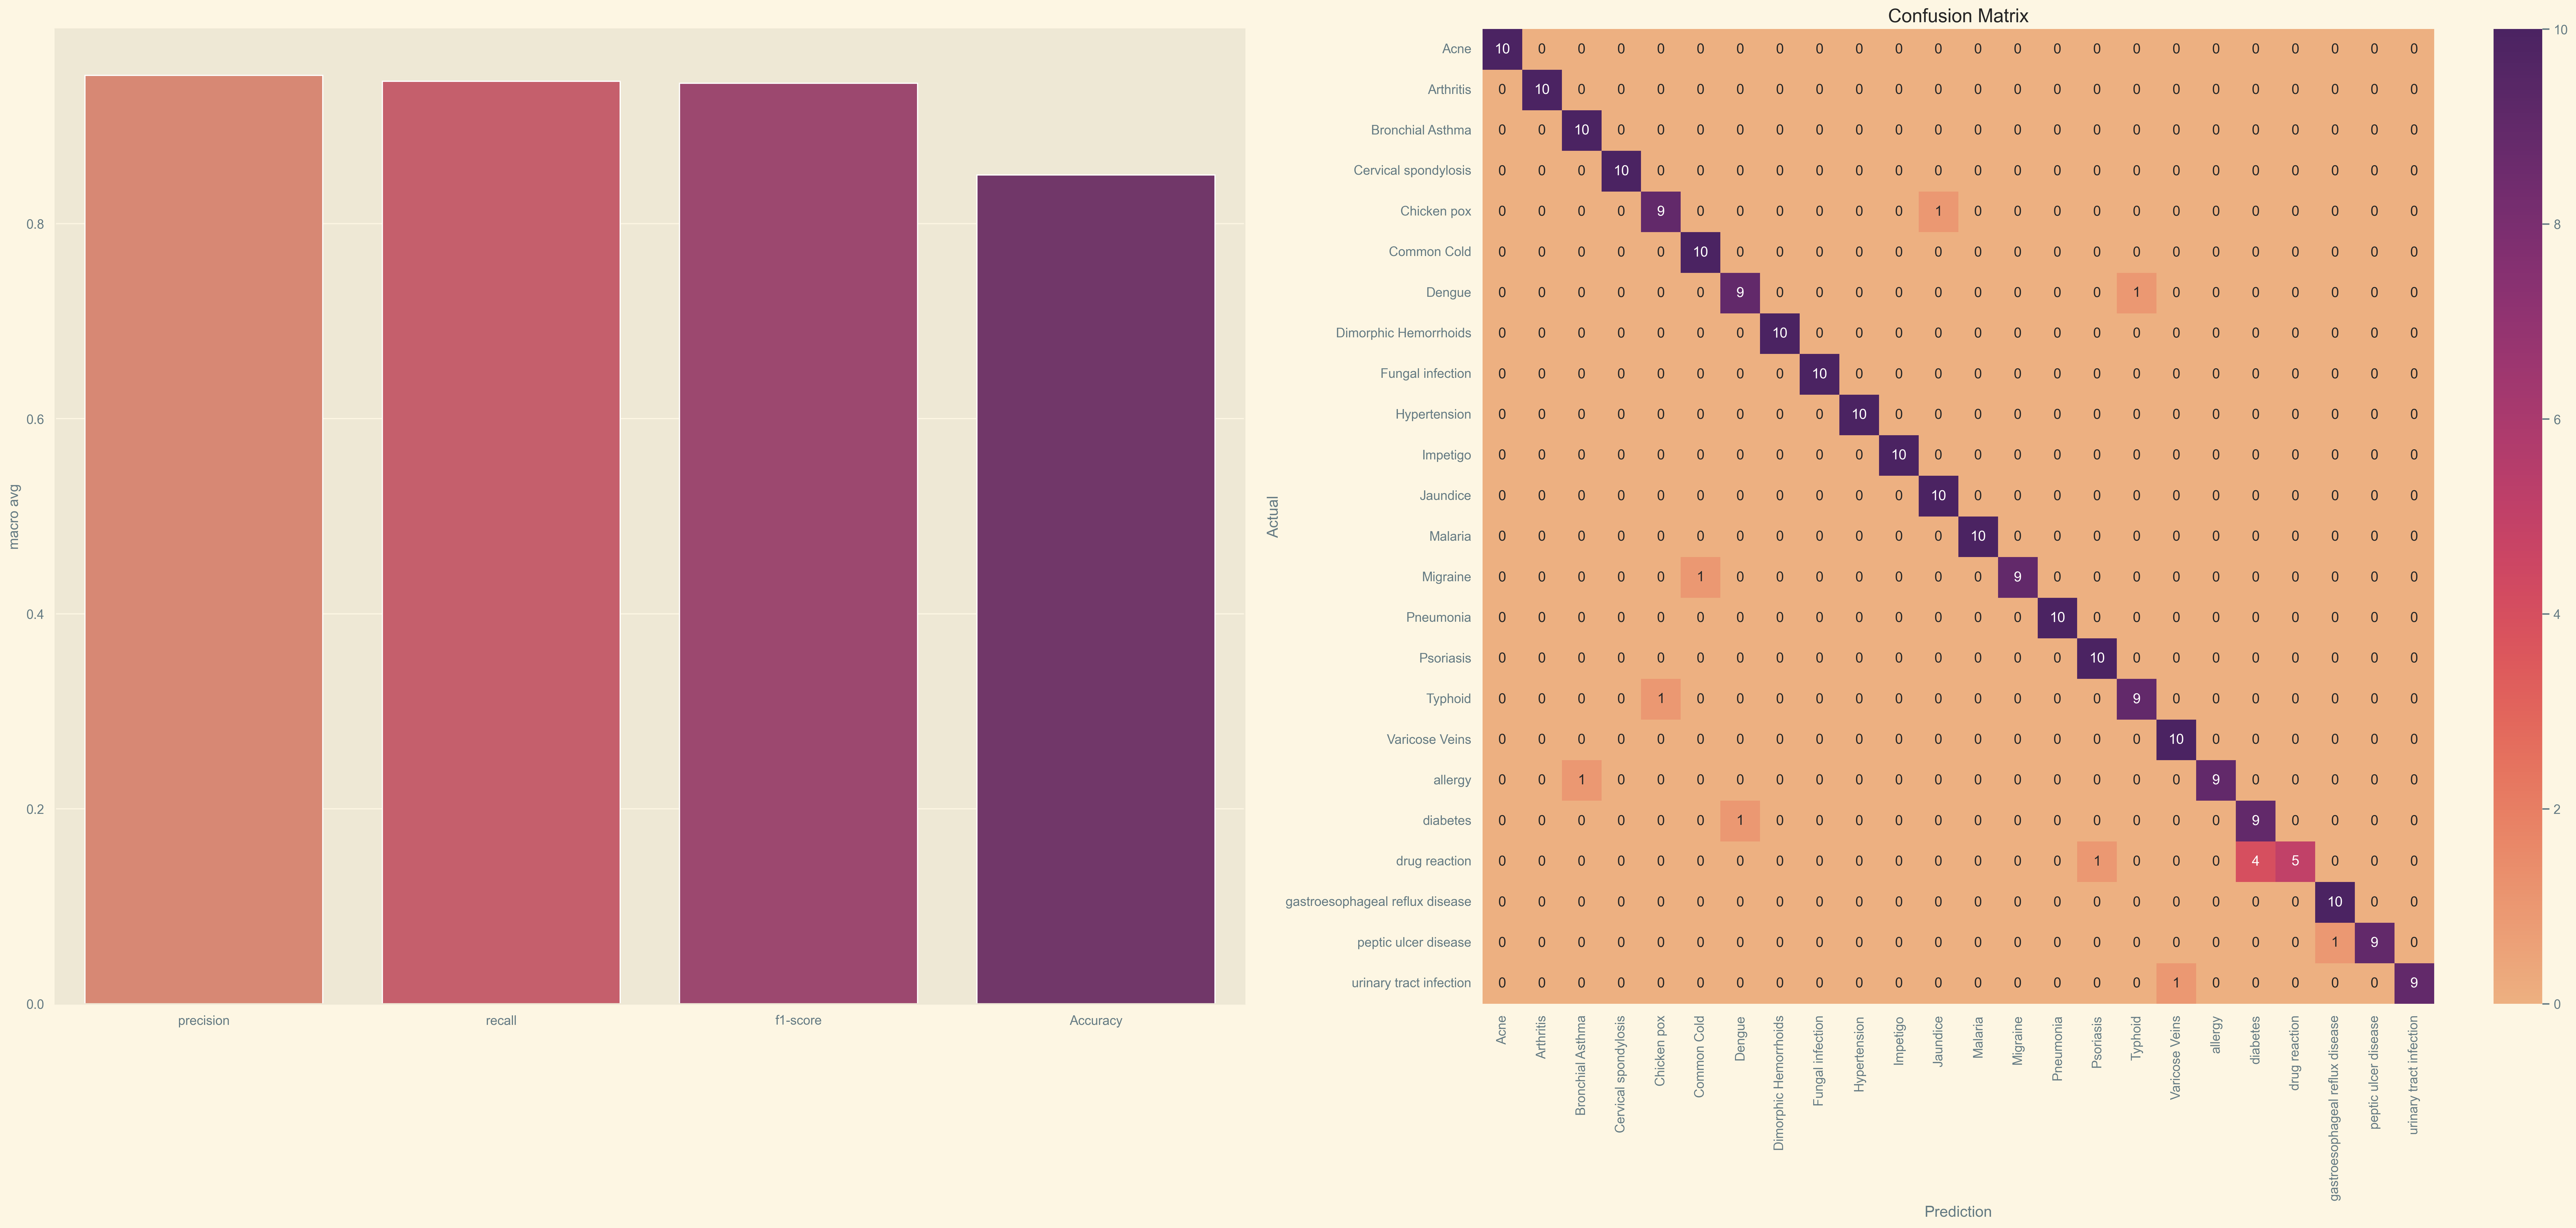

In [226]:
metrics_att = att_report['macro avg'].drop(labels='support', axis=0)
metrics_att.loc['Accuracy'] = att_acc 
cm_att  = confusion_matrix(y_test, att_preds)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(40,15), dpi=300)
sns.barplot(metrics_att, ax=ax1, palette='flare')
plot_confusion_matrix(cm_att, ax2, att_report, class_labels, att=True)
fig.savefig('att_metrics.png')

In [154]:
metrics_att

precision    0.951952
recall       0.945833
f1-score     0.943876
Accuracy     0.850000
Name: macro avg, dtype: float64

Now that we have our predictions with the attention layer we can inspect the attention weights

In [155]:
attention_weights.shape # We have the scores of for each hidden state in the LSTM = 33

(240, 33, 1)

In [165]:
attention_weights[45] 

array([[9.7593067e-07],
       [9.7593067e-07],
       [9.7593067e-07],
       [9.7593067e-07],
       [9.7593067e-07],
       [9.7593067e-07],
       [9.7593067e-07],
       [9.7593067e-07],
       [9.7593067e-07],
       [9.7593067e-07],
       [9.7593067e-07],
       [9.7593067e-07],
       [9.7593067e-07],
       [9.7593067e-07],
       [2.7371096e-04],
       [2.6912001e-04],
       [2.6324909e-04],
       [3.6764910e-04],
       [1.0682733e-02],
       [1.3208906e-01],
       [2.0426498e-03],
       [2.7397536e-02],
       [3.6573904e-03],
       [2.3262301e-02],
       [4.8565445e-03],
       [8.8842548e-03],
       [1.6780814e-02],
       [7.3731285e-01],
       [5.4508778e-03],
       [8.8138226e-03],
       [7.2194873e-03],
       [9.5794238e-03],
       [7.8294741e-04]], dtype=float32)

These are all probabilities that add up to 1. As we can see for the first entries we have really low values these entries correspond to the padded values of our sequence, it means that attention it's working as it is giving no focus / importance to padded values.

In [161]:
def attention_inspect(attention_weights : np.array, vocab : dict, X_test : np.array, pred : int, n : int):
    """
    This function will print the top n most relevant words for a given prediction according to the attention mechanism
    """
    att_weights_sort = np.sort(attention_weights[1], axis=0)
    highest = [np.where(attention_weights[1] == high)[0][0] for high in att_weights_sort[-n:]]
    relevant_words = [list(vocab.keys())[list(vocab.values()).index(X_test[pred][i])] for i in highest]
    print(f"relevant words for {pred} prediction: {', '.join(word for word in relevant_words)}")

In [237]:
attention_inspect(attention_weights, vocab, X_test, 45, 10)

 relevant words for 45 prediction: mind, pounding, difficulties, feel, heart, nauseous, lightheaded, hazy, little, everything


## Fine-Tuning a pre-trained BERT model with our dataset

In [38]:
from transformers import TFBertModel, BertConfig, TFBertForSequenceClassification

@keras.saving.register_keras_serializable()
class BertLayer(layers.Layer):
    """Changing the BERT's layers input as there was a mismatch with tensorflow updates"""
    def __init__(self, bert_model_name, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained(bert_model_name, from_pt=True)
        
    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

def model_bert(
    bert_model_name : str, input_shape : int, rate : float, 
    num_classes : int, learning_rate : float,
    batch_size : int,
    out_activation='softmax',
    loss='sparse_categorical_crossentropy'
):
    input_ids = tf.Input(shape=(input_shape,), batch_size=batch_size, dtype=tensorflow.int32, name="input_ids")
    attention_masks = tf.Input(shape=(input_shape,), batch_size=batch_size, dtype=tensorflow.int32, name="attention_mask")
    
    # Get the BERT model outputs
    bert_output = BertLayer(bert_model_name)([input_ids, attention_masks])
    
    # Get only the outputs after the [CLS] token
    cls_output = bert_output[:,0,:]
    x = layers.Dropout(rate)(cls_output)
    output = layers.Dense(num_classes, activation=out_activation)(x)
    
    model = Model(inputs = [input_ids ,attention_masks], outputs = output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=[tf.metrics.SparseCategoricalAccuracy()])
    return model

In [41]:
bert_model_name = "bert-base-uncased"
bert_test = model_bert(bert_model_name, bert_tokens.shape[1], 0.5, 24, 0.006, 32)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [40]:
params_bert = {
    'embedding_dimension' : [0],
    'n_units' : [0],
    'learning_rate' : np.random.uniform(0.001, 0.01, size=4),
    'dropout_rate' : np.random.uniform(0.3, 0.7, size=4)
}

bert_tokens, bert_masks = pre_process.tokenization_bert(33)

X_train_tokens, X_test_tokens, y_train_bert, y_test_bert, train_masks, test_masks = train_test_split(
    bert_tokens, y_int, bert_masks, test_size=0.2, stratify=y_int, random_state=42)

In [ ]:
# bert_model, bert_score, bert_hyperparameters = cross_validation(X_train=X_train_tokens, Y_train=y_train_bert, 
#                              params=params_bert, input_shape=X_train_tokens.shape[1], 
#                              batch_size=32, n_unique_words=len(vocab), num_classes=len(target), class_labels=class_labels, bert=True, 
#                              bert_model_name=bert_model_name, attention_mask=train_masks)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Training fold 0 with parameters:
Learning Rate: 0.008370799967404698
Dropout Rate: 0.4406165755055433

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - loss: 3.5646 - sparse_categorical_accuracy: 0.0503
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 2.5753 - sparse_categorical_accuracy: 0.2789
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 1.9689 - sparse_categorical_accuracy: 0.5053
Epoch 4/10
 3/20 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - loss: 1.6487 - sparse_categorical_accuracy: 0.6146

In [47]:
bert_test.fit(
    x=[X_train_tokens, train_masks],
    y=y_train_bert,
    epochs=50)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 490ms/step - loss: 0.5193 - sparse_categorical_accuracy: 0.8388
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 485ms/step - loss: 0.5307 - sparse_categorical_accuracy: 0.8402
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 484ms/step - loss: 0.5504 - sparse_categorical_accuracy: 0.8288
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 526ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.8393
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 532ms/step - loss: 0.4909 - sparse_categorical_accuracy: 0.8609
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 534ms/step - loss: 0.5720 - sparse_categorical_accuracy: 0.8310
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 494ms/step - loss: 0.5422 - sparse_categorical_accuracy: 0.8334
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 487ms/step - loss: 0.4874 - sparse_categorical_accuracy: 0.8593
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 488ms/step - loss: 0.5176 - sparse_categorical_accuracy: 0.8574
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 489

In [52]:
bert_test.save('BERT_test.keras')

In [53]:
bert_test = tf.models.load_model('BERT_test.keras')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [54]:
pred_bert = bert_test.predict([X_test_tokens, test_masks])
preds_bert = np.argmax(pred_bert, axis=1)
acc_bert = np.mean([1 if y_test_bert[i] == preds_bert[i] else 0 for i in range(len(preds_bert))])

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 803ms/step


In [56]:
preds_bert

array([ 5,  6, 10,  7,  1, 11,  4,  5,  3,  5,  0, 10, 22,  9,  4, 10, 20,
       10,  6,  0, 10,  5, 10, 18, 13, 22, 17,  2, 15, 17,  8, 16,  6,  1,
       19, 17,  3, 10, 21, 16,  5, 13,  1,  3,  2, 20, 12, 21,  7, 21,  8,
        3,  2,  6, 22,  5,  1,  3,  6, 21, 20, 11,  0, 15,  8,  5, 21, 10,
       19, 16, 14, 21, 21, 22,  0, 11, 16,  9, 12,  1,  9,  9, 21,  0, 11,
        0,  8, 19, 13, 11, 10,  6, 14, 13, 21, 22, 14,  7, 16, 16, 16, 10,
        1, 23, 16, 12, 18, 21,  4,  2,  6, 18,  7, 14,  1,  3, 16,  9, 20,
       18, 13, 22,  4,  8,  4, 21,  3,  9, 17, 13, 10, 21,  5, 16, 19,  4,
       18, 22,  9,  2, 15, 19, 12, 12,  0, 20,  0, 23, 13,  8, 22, 14, 11,
       10, 21, 20,  4, 11, 12,  5, 17, 11, 20, 20,  4,  5,  7, 15,  5,  3,
        7, 21,  9,  0,  9, 21,  8, 13,  7, 17,  0,  5, 15,  5, 20, 14, 13,
        3, 20, 15,  2,  5,  4, 12,  7, 20,  1, 14, 21,  6, 18,  5, 14,  3,
        2, 14, 12,  0,  4,  7, 21, 15, 14,  6, 12, 10,  4, 10,  1, 17,  4,
        1,  4, 16,  3, 20

In [57]:
acc_bert

0.7041666666666667

In [166]:
bert_report = class_report(y_true=y_test_bert, y_pred=preds_bert, class_labels=class_labels)
bert_report.to_csv('BERT.csv', index=True)
bert_report

Acne  Arthritis  Bronchial Asthma  Cervical spondylosis  \
precision   0.909091   0.909091          0.750000              0.750000   
recall      1.000000   1.000000          0.600000              0.900000   
f1-score    0.952381   0.952381          0.666667              0.818182   
support    10.000000  10.000000         10.000000             10.000000   

           Chicken pox  Common Cold     Dengue  Dimorphic Hemorrhoids  \
precision     0.571429     0.533333   0.555556                    1.0   
recall        0.800000     0.800000   0.500000                    1.0   
f1-score      0.666667     0.640000   0.526316                    1.0   
support      10.000000    10.000000  10.000000                   10.0   

           Fungal infection  Hypertension  ...  Varicose Veins    allergy  \
precision          0.875000      1.000000  ...        1.000000   0.333333   
recall             0.700000      0.900000  ...        0.700000   0.200000   
f1-score           0.777778      0.947368  ...        0.823529   0.250000   
support           10.000000     10.000000  ...       10.000000  10.000000   

            diabetes  drug reaction  gastroesophageal reflux disease  \
precision   0.200000       0.285714                         0.555556   
recall      0.100000       0.400000                         1.000000   
f1-score    0.133333       0.333333                         0.714286   
support    10.000000      10.000000                        10.000000   

           peptic ulcer disease  urinary tract infection  accuracy  \
precision              0.555556                 1.000000  0.704167   
recall                 0.500000                 0.200000  0.704167   
f1-score               0.526316                 0.333333  0.704167   
support               10.000000                10.000000  0.704167   

            macro avg  weighted avg  
precision    0.725750      0.725750  
recall       0.704167      0.704167  
f1-score     0.693895      0.693895  
support    240.000000    240.000000  

[4 rows x 27 columns]

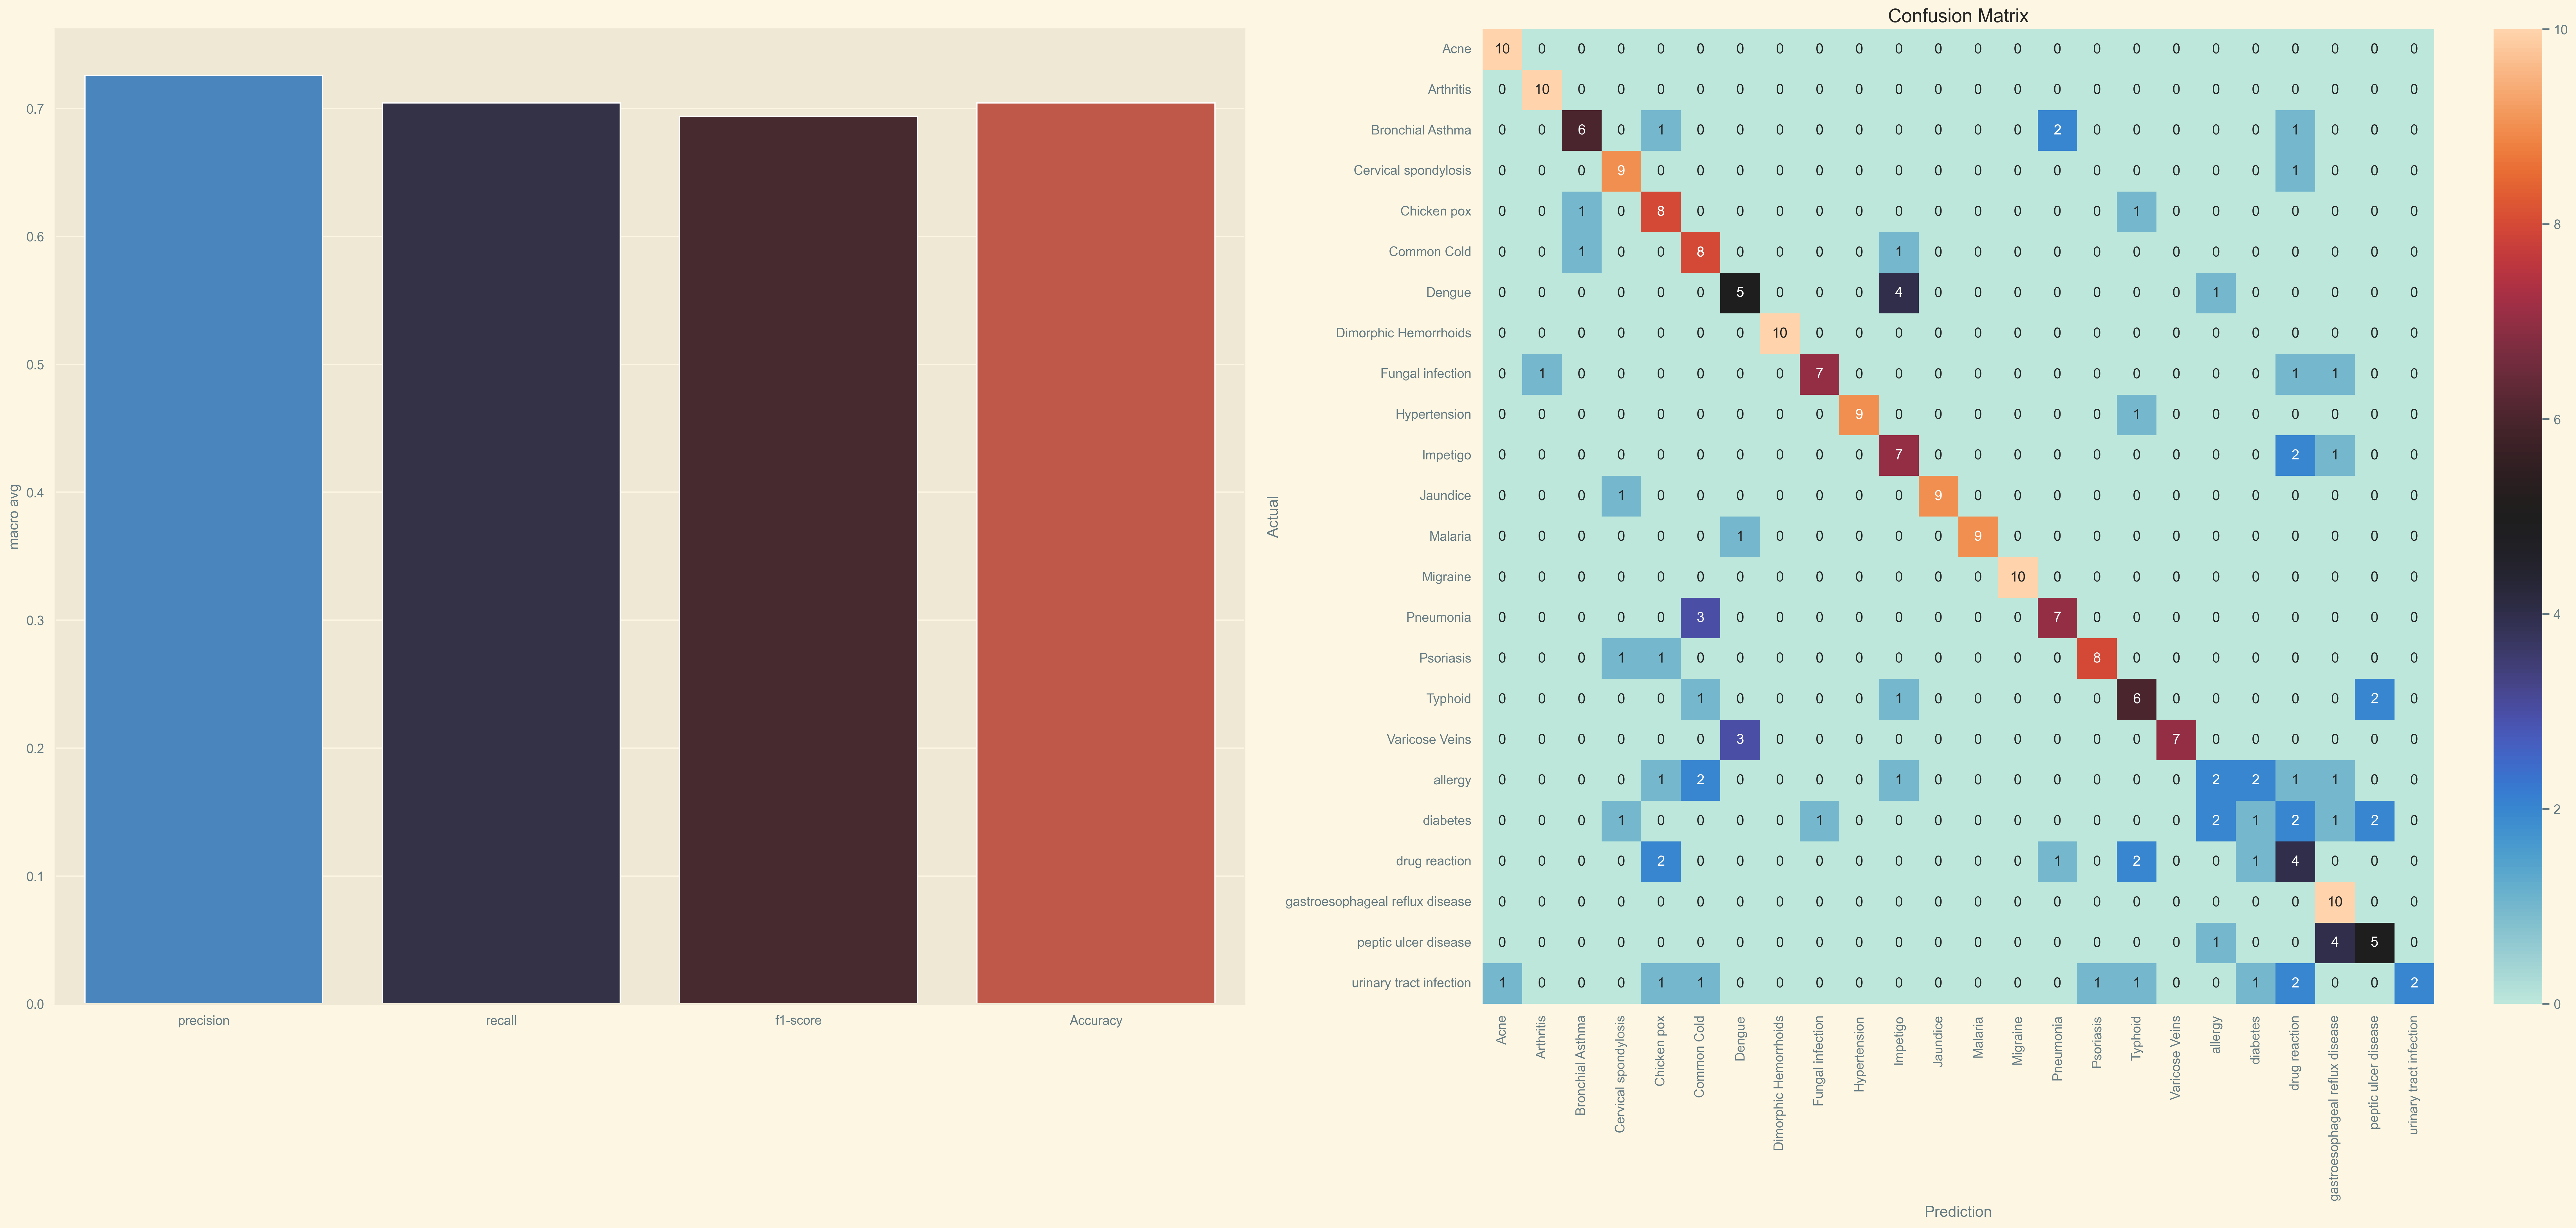

In [227]:
metrics_bert = bert_report['macro avg'].drop(labels='support', axis=0)
metrics_bert.loc['Accuracy'] = acc_bert 
cm_bert  = confusion_matrix(y_test_bert, preds_bert)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(40,15), dpi=300)
sns.barplot(metrics_bert, ax=ax1, palette='icefire')
plot_confusion_matrix(cm_bert, ax2, bert_report, class_labels, bert=True)
fig.savefig('BERT.png')